In [228]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from bootcampviztools import plot_categorical_relationship_fin, pinta_distribucion_categoricas, plot_multiple_boxplots, plot_grouped_boxplots, plot_grouped_histograms, grafico_dispersion_con_correlacion, plot_histo_dens

In [229]:
df_vehiculos = pd.read_csv('./data/vehiculos_uy_final')

In [230]:
# Filtrar vehículos nuevos y usados del DataFrame original
vehiculos_nuevos = df_vehiculos[df_vehiculos['condicion'] == 'Nuevo']
vehiculos_usados = df_vehiculos[df_vehiculos['condicion'] == 'Usado']


In [231]:
# Calcular el promedio de precios de vehículos nuevos por combinación de marca, modelo y versión
promedio_precios_nuevos = vehiculos_nuevos.groupby(['marca', 'modelo', 'version', 'tipo_combustible'])['precio'].mean().reset_index()
promedio_precios_nuevos['precio'] = promedio_precios_nuevos['precio'].round(0)

In [232]:
# Filtrar vehículos nuevos y usados del DataFrame original
vehiculos_nuevos = df_vehiculos[df_vehiculos['condicion'] == 'Nuevo']
vehiculos_usados = df_vehiculos[df_vehiculos['condicion'] == 'Usado']

# Calcular el promedio de precios de vehículos nuevos por combinación de marca, modelo y versión
promedio_precios_nuevos = vehiculos_nuevos.groupby(['marca', 'modelo', 'version'])['precio'].mean().reset_index()

# Contar la cantidad de vehículos usados por cada combinación de marca, modelo y versión
conteo_usados = vehiculos_usados.groupby(['marca', 'modelo', 'version']).size().reset_index(name='cantidad_usados')

# Filtrar combinaciones con al menos 5 vehículos usados
combinaciones_validas = conteo_usados[conteo_usados['cantidad_usados'] >= 4]

# Filtrar vehículos usados con las combinaciones válidas
vehiculos_usados_filtrados = pd.merge(vehiculos_usados, combinaciones_validas[['marca', 'modelo', 'version']], on=['marca', 'modelo', 'version'], how='inner')

# Añadir el precio promedio de vehículos nuevos a los vehículos usados
vehiculos_usados_filtrados = pd.merge(vehiculos_usados_filtrados, promedio_precios_nuevos, on=['marca', 'modelo', 'version'], how='left', suffixes=('_usado', '_nuevo'))

# Verificar NaN en precio_nuevo
nan_precio_nuevo = vehiculos_usados_filtrados[vehiculos_usados_filtrados['precio_nuevo'].isna()]

# Calcular la depreciación
vehiculos_usados_filtrados['depreciacion'] = (vehiculos_usados_filtrados['precio_nuevo'] - vehiculos_usados_filtrados['precio_usado']) / vehiculos_usados_filtrados['precio_nuevo'] * 100

# Verificar cantidad de depreciaciones negativas
depreciacion_negativa = vehiculos_usados_filtrados[vehiculos_usados_filtrados['depreciacion'] < 0]

# Filtrar vehículos con depreciación negativa
vehiculos_usados_filtrados = vehiculos_usados_filtrados[vehiculos_usados_filtrados['depreciacion'] >= 0]

# Recalcular el conteo de vehículos usados después de filtrar depreciación negativa
conteo_usados_filtrados = vehiculos_usados_filtrados.groupby(['marca', 'modelo', 'version']).size().reset_index(name='cantidad_usados')

# Filtrar nuevamente combinaciones válidas con al menos 5 vehículos usados
combinaciones_validas_finales = conteo_usados_filtrados[conteo_usados_filtrados['cantidad_usados'] >= 4]

# Filtrar vehículos usados con las combinaciones válidas finales
df_vehiculos_depreciacion = pd.merge(vehiculos_usados_filtrados, combinaciones_validas_finales[['marca', 'modelo', 'version']], on=['marca', 'modelo', 'version'], how='inner')


In [233]:
df_vehiculos_depreciacion.version.describe()

count                 1532
unique                 130
top       1.6 Exclusive At
freq                    73
Name: version, dtype: object

In [234]:
df_vehiculos_depreciacion.loc[df_vehiculos_depreciacion['depreciacion'] < 0]

,id,titulo,moneda,precio_usado,marca,modelo,version,condicion,anio_vehiculo,kilometraje,...,tienda_oficial,id_seller,nickname,fecha_baja_publicacion,tipo_anuncio,enlace_publicacion,cat_kilometros,segmento_economico,precio_nuevo,depreciacion


In [235]:
#Se vuelve a aplicar la función ya que se modificó el nombre de la columna
def clasificar_segmento(row):
    if row['precio_nuevo'] > 100000:
        return 'Vehículos de lujo'
    elif row['precio_nuevo'] > 60000:
        return 'Gama alta'
    elif row['precio_nuevo'] > 30000:
        return 'Gama media alta'
    elif row['precio_nuevo'] > 15000:
        return 'Gama media'
    else:
        return 'Gama baja'

# Aplicar la función a cada fila para crear la nueva columna
df_vehiculos_depreciacion['segmento_economico'] = df_vehiculos_depreciacion.apply(clasificar_segmento, axis=1)

In [236]:
df_vehiculos_depreciacion.segmento_economico.value_counts()

segmento_economico
Gama media         969
Gama media alta    373
Gama baja          100
Gama alta           90
Name: count, dtype: int64

In [237]:
# Se unifican los caso Automática secuencial en Automático
df_vehiculos_depreciacion.loc[df_vehiculos_depreciacion['transmision'] == 'Automática secuencial', 'transmision'] = 'Automática'

Es decir que tengo 102 versiones de diferentes marcas y modelos con los que podré trabajar, para realizar un análisis de depreciación, teniendo en cuenta diversos factores

## A continuación se presenta el cuadro que tipifica las distintas variantes


In [238]:
df_tipificacion = pd.DataFrame([df_vehiculos_depreciacion.nunique(), df_vehiculos_depreciacion.nunique()/len(df_vehiculos_depreciacion) * 100, 
                                df_vehiculos_depreciacion.dtypes]).T.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"})
df_tipificacion["Clasificada_como"] = "Categorica" 
df_tipificacion.loc[df_tipificacion.Card == 2, "Clasificada_como"] = "Binaria"
df_tipificacion.loc[df_tipificacion["Card"] > 10, "Clasificada_como"] ="Numerica Discreta"
df_tipificacion.loc[df_tipificacion["%_Card"] > 30, "Clasificada_como"] = "Numerica Continua"
df_tipificacion

,Card,%_Card,Tipo,Clasificada_como
id,1532,100.0,object,Numerica Continua
titulo,1080,70.496084,object,Numerica Continua
moneda,1,0.065274,object,Categorica
precio_usado,399,26.044386,float64,Numerica Discreta
marca,23,1.501305,object,Numerica Discreta
modelo,71,4.634465,object,Numerica Discreta
version,130,8.48564,object,Numerica Discreta
condicion,1,0.065274,object,Categorica
anio_vehiculo,20,1.305483,int64,Numerica Discreta
kilometraje,559,36.488251,int64,Numerica Continua


| Nombre del campo| Descripción              | Tipo de variable  | Importancia Inicial | Notas                 |
|-----------------|--------------------------|-------------------|---------------------|-----------------------|
| id              | ID de la publicación     | Índice Único        | -                   | Identificador único de la publicación    |
| moneda          | Moneda en USD             | Valor único        | -                   | Indica la moneda del precio - Dólares (USD) |
| precio_usado          | Indica el precio del vehículo| Numerica Contínua | 0               | Indicador precio del vehículo al que se ofrece usado |
| marca           | Indica la marca del vehículo | Categórica  | 1              | Es un valor muy importante para el análisis |
| modelo          | Subcategoría dentro de la marca | Categórica| 2         | También es un factor muy relevante para el análisis |
| version         | Subcategoría dentro del modelo | Categórica | 3              | Determina la variante dentro del modelo, en general refiere a los distintos atributos, por ejemplo extras de confort, seguridad, etc.  |
| condicion       | Indica si es nuevo o usado  | Binaria         | 1                 | Es un factor fundamental para filtrar los vehículos usados o nuevos |
| anio_vehiculo   | Indica el año del vehículo | Numerica Discreta | 2                | Esto indica el año de fabricación del vehículo aunque no queda claro si en algunos casos se le asigna según el primer año de uso|
| kilometraje     | Indica el kilometraje del vehículo     | Numerica Contínua     | 2               | Es importante para determinar el desgaste del vehículo  |
| potencia        | Indica la potencia medida en caballos de fuerza (hp) | Numerica Discreta | 3   | Está relaiconado con la versión|
| transmision    | Indica el tipo de transmisión   | Categórica            | 3      | Podría tener relevancia si supiéramos como incide en el comprador |
| control_traccion | Indica la tracción del vehículo | Categórica          | 3      | Podría tener relevancia si supiéramos como incide en el comprador             |
| tipo_combustible | Indica el tipo de combusitble que utiliza el vehículo | Categórica   | 3   | Es importante sobre todo para filtrar a los eléctricos, mercado en crecimiento |
| aire_acondicionado | Indica si el vehículo cuenta con A/C | Binaria     | 3            | Al no ser un atirbuto obligatorio, faltan datos sobre muchos vehículos|
| color     | Indica el color del vehículo | Categórica      | 3            | A priori no tendría influencia en el precio, preferencias subjetivas  |
| tienda_oficial | Indica si se trata de una tienda oficial reconocida por ML | Categórica  | 3   | Se observan automotoras importantes que no tienen este reconocimiento, valor difícil de ponderar  |
| id_seller | El id que tiene el usuario que publica el vehículo   | Índice único para cada usuario   | 3    | Importante para medir publicaciones por usuario, ponderaría más si mi enfoque fuera sobre usuarios. También puede servir para trabajar con otras base de datos. |
| nickname  | Indica el nombre que tiene el usuario en ML | Valor único para cada usuario          |3 | ídem id_seller|
| fecha_baja_publicacion  | Indica la fecha a la cual bajaría la publicación  | Fecha           | -    | https://www.mercadolibre.com.uy/ayuda/costos-de-vehiculo_868  Las publicaicones Oro, Plata y Gratis tienen 30 días de duración, las Oro Preminun pueden ser republicadas por un año sin costo. También pueden ser republicadas las otras con costo |
| tipo_anuncio  | Indica el tipo de anuncio  | Categórica            | -            | Según el tipo de anuncio (Gratis, Plata, Oro y Oro Premiun) tienen distinta visibilidad y otros beneficios |
| enlace_publicacion    | Contiene el link de la publicación   | -            | -                  | CSirve para verificar información o simplemente a modo informativo   |
| cat_kilometraje    | Columna creada, asigna una categoría según cantidad de kilómetros  | Categórica |   1  | Es un gran indicador para categorizar el estado del vehículo   |
| segmento_economico    | Columna creada, asigna una categoría según el segmento económico  | Categórica |   1  | Es una categoría importante para analizar los segmentos por separado |
| precio_nuevo          | Indica el precio del vehículo en estado nuevo| Numerica Contínua | 1              | Indicador precio del vehículo al que se ofrece nuevo |
| depreciacion    | Columna creada, se calcula como la diferencia porcentual entre el precio usado vs nuevo  | Numérica contínua |   1  | Es una categoría importante para analizar la depreciación de los vehículos|

# Análisis 

In [239]:
df_vehiculos_depreciacion.describe()

,precio_usado,anio_vehiculo,kilometraje,puertas,id_seller,precio_nuevo,depreciacion
count,1532.000000,1532.000000,1.532000e+03,1532.000000,1.532000e+03,1532.000000,1532.000000
mean,19889.624021,2019.590731,8.323609e+04,4.503264,3.623058e+08,28656.046987,27.461347
std,9691.896337,2.993176,7.159793e+04,0.798833,4.335461e+08,15550.503565,15.353555
min,5000.000000,1998.000000,3.300000e+01,2.000000,9.887700e+04,10400.000000,0.000000
25%,13490.000000,2018.000000,4.143500e+04,4.000000,9.011949e+07,17990.000000,15.113351
50%,16990.000000,2020.000000,7.400000e+04,5.000000,1.760376e+08,23840.000000,26.395717
75%,23422.500000,2022.000000,1.060000e+05,5.000000,4.190482e+08,32867.500000,37.500000
max,65990.000000,2024.000000,1.111111e+06,5.000000,1.911492e+09,90000.000000,94.444444


In [240]:
def variabilidad(df):
    df_var = df.describe().loc[['std','mean']].T
    df_var['CV'] = df_var['std']/df_var['mean']
    return df_var

In [241]:
variabilidad(df_vehiculos_depreciacion)

,std,mean,CV
precio_usado,9.691896e+03,1.988962e+04,0.487284
anio_vehiculo,2.993176e+00,2.019591e+03,0.001482
kilometraje,7.159793e+04,8.323609e+04,0.860179
puertas,7.988331e-01,4.503264e+00,0.177390
id_seller,4.335461e+08,3.623058e+08,1.196630
precio_nuevo,1.555050e+04,2.865605e+04,0.542660
depreciacion,1.535355e+01,2.746135e+01,0.559097


In [242]:
# Análizando la moda en las categóricas
categoricas_vehiculos = [
    'marca',
    'modelo',
    'version',
    'transmision',
    'control_traccion',
    'tipo_combustible',
    'aire_acondicionado',
    'color',
    'tienda_oficial',
    'tipo_anuncio',
    'cat_kilometros',
    'segmento_economico',
]

In [243]:
df_vehiculos_depreciacion[categoricas_vehiculos].mode().T

,0
marca,Suzuki
modelo,Celerio
version,1.6 Exclusive At
transmision,Manual
control_traccion,Delantera
tipo_combustible,Nafta
aire_acondicionado,Sí
color,color_no_especificado
tienda_oficial,Tienda no oficial
tipo_anuncio,gold_premium


In [244]:
for catego in categoricas_vehiculos: 
    print(f'Para {catego}')
    print(df_vehiculos_depreciacion[catego].value_counts())
    print('\n'*2)

Para marca
marca
Suzuki        259
Nissan        179
Peugeot       175
Renault       171
Chevrolet     152
Volkswagen    122
Fiat          100
Hyundai        96
Toyota         69
Citroën        53
Honda          35
Jetour         21
BMW            17
Jeep           15
Geely          13
Chery          11
Great Wall     11
Ford            8
Mitsubishi      6
BYD             6
Karry           5
JAC             4
Mazda           4
Name: count, dtype: int64



Para modelo
modelo
Celerio    121
Kwid       102
208        101
Kicks       85
Onix        84
          ... 
Tucson       4
WR-V         4
Pulse        4
T6           4
Duster       4
Name: count, Length: 71, dtype: int64



Para version
version
1.6 Exclusive At                 73
1.0 Ga 5p                        59
1.0 Gl 5p                        49
1.0 Sce 66cv Intense             42
1.6 Dynamique                    42
                                 ..
1.6 Trendlinde At                 4
1.6 Sense Mt                      4
2.0 Cd

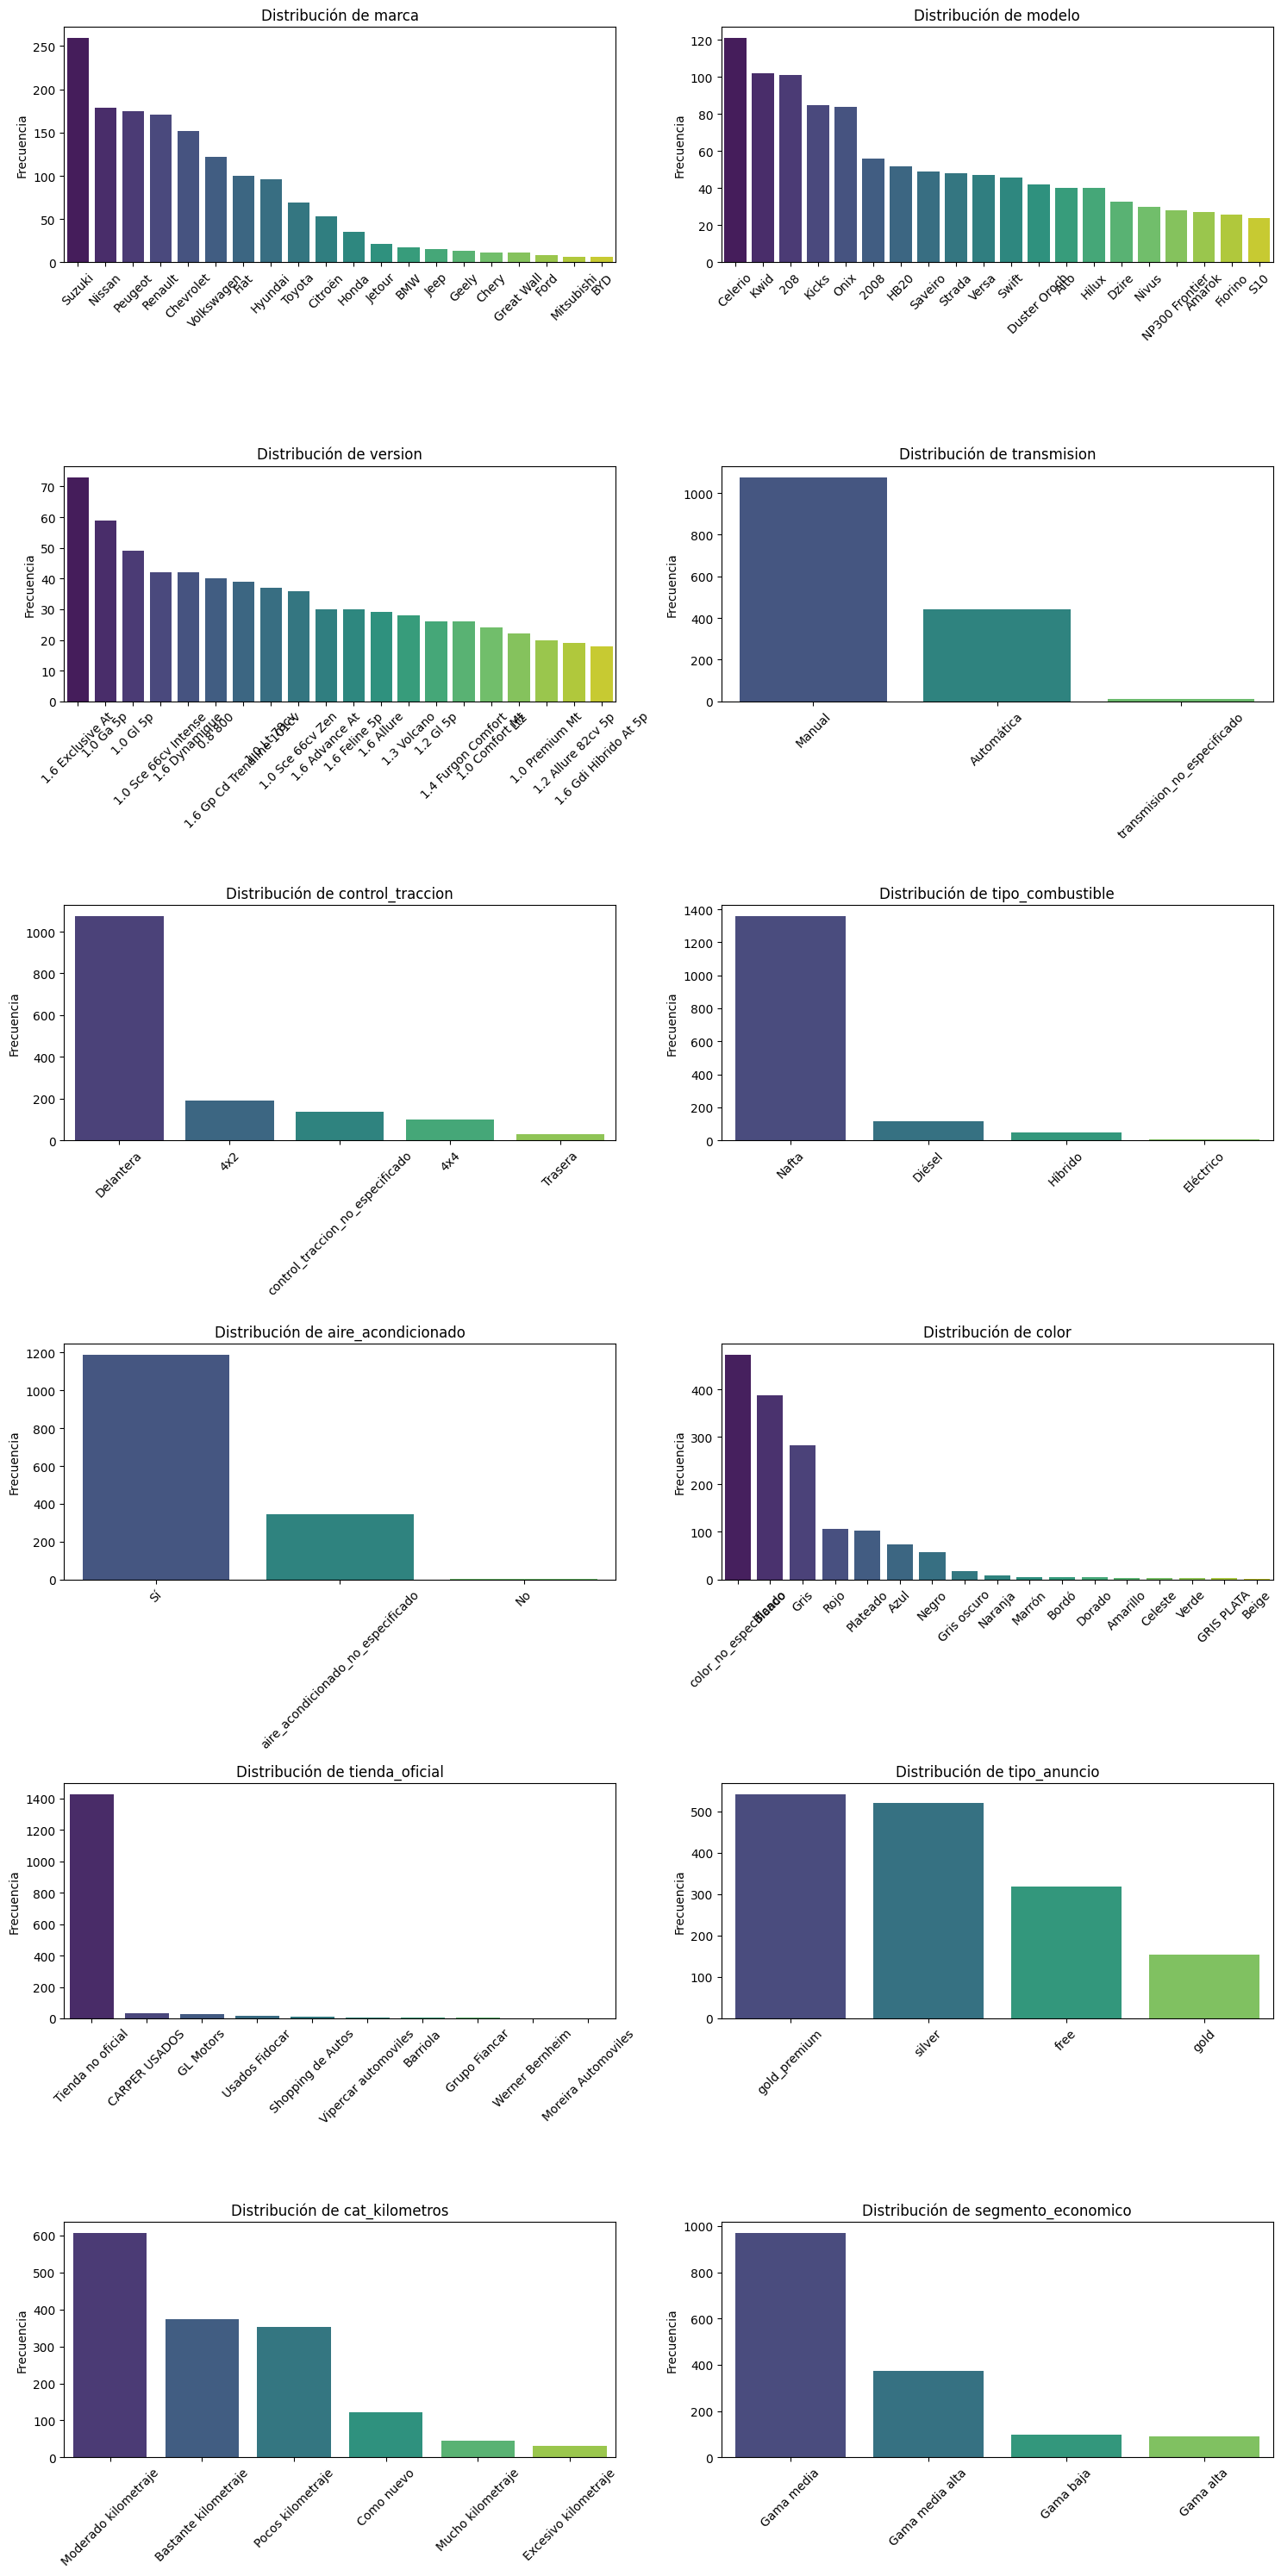

In [245]:
pinta_distribucion_categoricas(df_vehiculos_depreciacion, categoricas_vehiculos)
#Muestro solo los primeros 20 resultados para mejor visualización

In [246]:
for catego in categoricas_vehiculos: 
    print(f'Para {catego}')
    print(df_vehiculos_depreciacion[catego].value_counts()/len(df_vehiculos_depreciacion)*100)
    print('\n'*2)

Para marca
marca
Suzuki        16.906005
Nissan        11.684073
Peugeot       11.422977
Renault       11.161880
Chevrolet      9.921671
Volkswagen     7.963446
Fiat           6.527415
Hyundai        6.266319
Toyota         4.503916
Citroën        3.459530
Honda          2.284595
Jetour         1.370757
BMW            1.109661
Jeep           0.979112
Geely          0.848564
Chery          0.718016
Great Wall     0.718016
Ford           0.522193
Mitsubishi     0.391645
BYD            0.391645
Karry          0.326371
JAC            0.261097
Mazda          0.261097
Name: count, dtype: float64



Para modelo
modelo
Celerio    7.898172
Kwid       6.657963
208        6.592689
Kicks      5.548303
Onix       5.483029
             ...   
Tucson     0.261097
WR-V       0.261097
Pulse      0.261097
T6         0.261097
Duster     0.261097
Name: count, Length: 71, dtype: float64



Para version
version
1.6 Exclusive At                 4.765013
1.0 Ga 5p                        3.851175
1.0 Gl 5p    

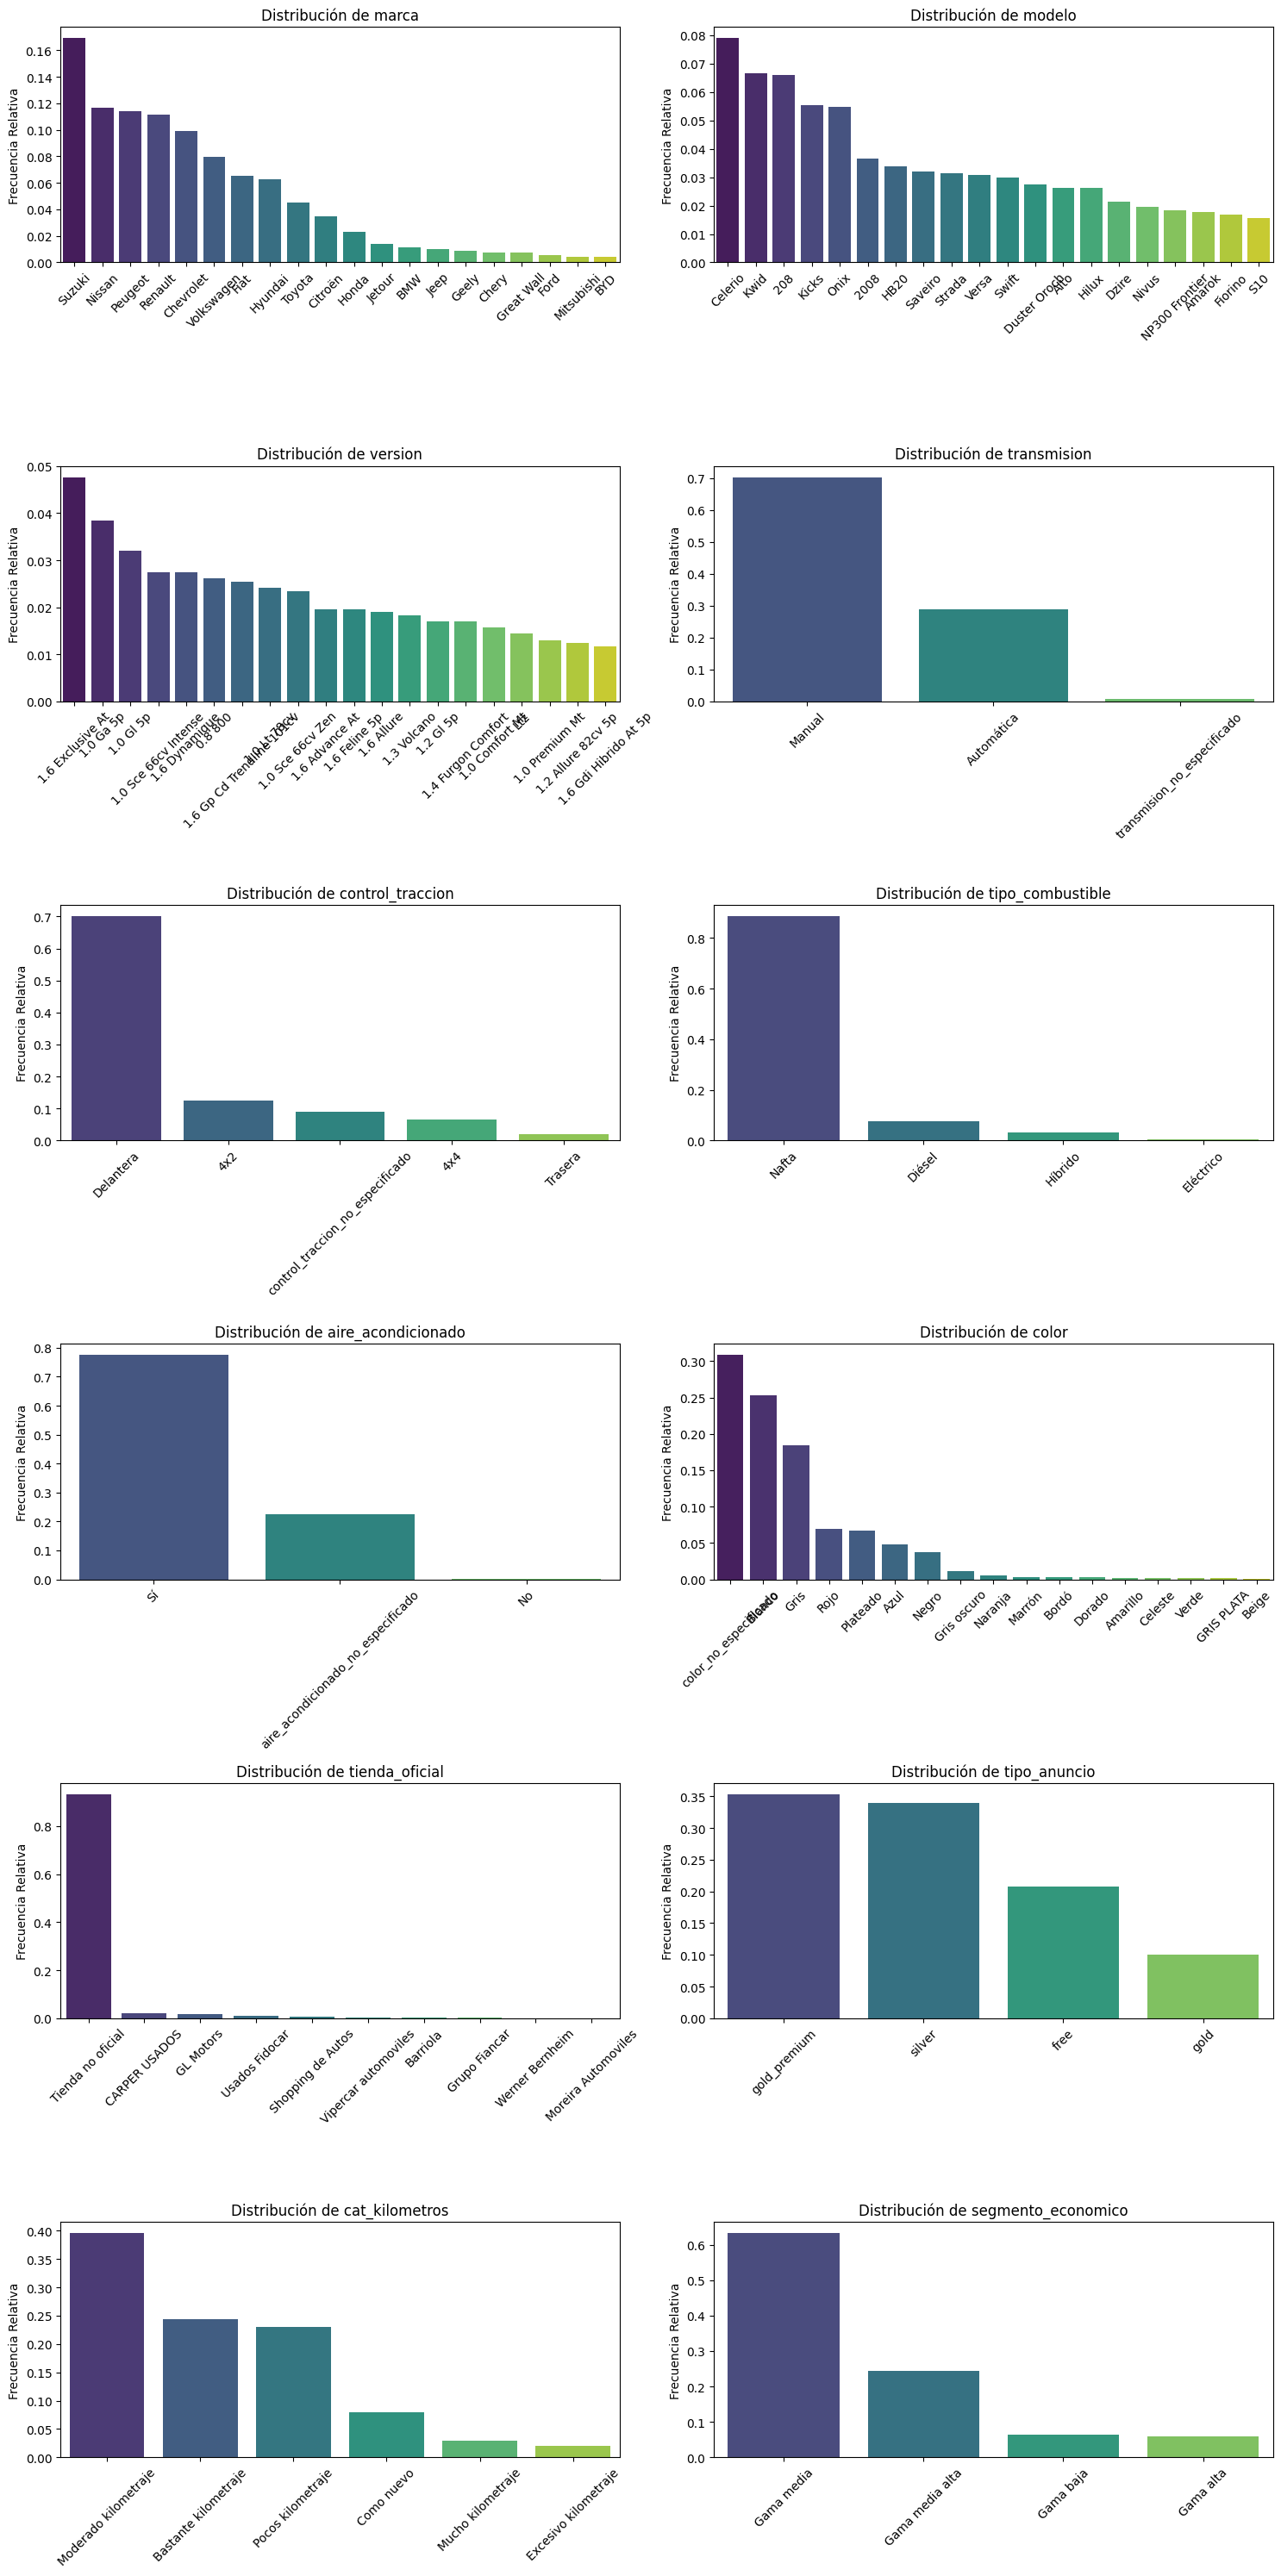

In [247]:
pinta_distribucion_categoricas(df_vehiculos_depreciacion, categoricas_vehiculos, relativa=True)
#Muestro solo los primeros 20 resultados para mejor visualización

## Medidas de posición

In [248]:
def plot_boxplot_grouped(df, column_to_plot, group_column):
    if df[column_to_plot].dtype in ['int64', 'float64'] and df[group_column].dtype in ['object', 'category']:
        sns.boxplot(data=df, x=group_column, y=column_to_plot)
        plt.show()

In [249]:
# columnas numéricas:
columnas_numericas_vehiculos = [
    "precio_usado",
    "anio_vehiculo",
    "kilometraje",
    "precio_nuevo",
    "depreciacion"
]

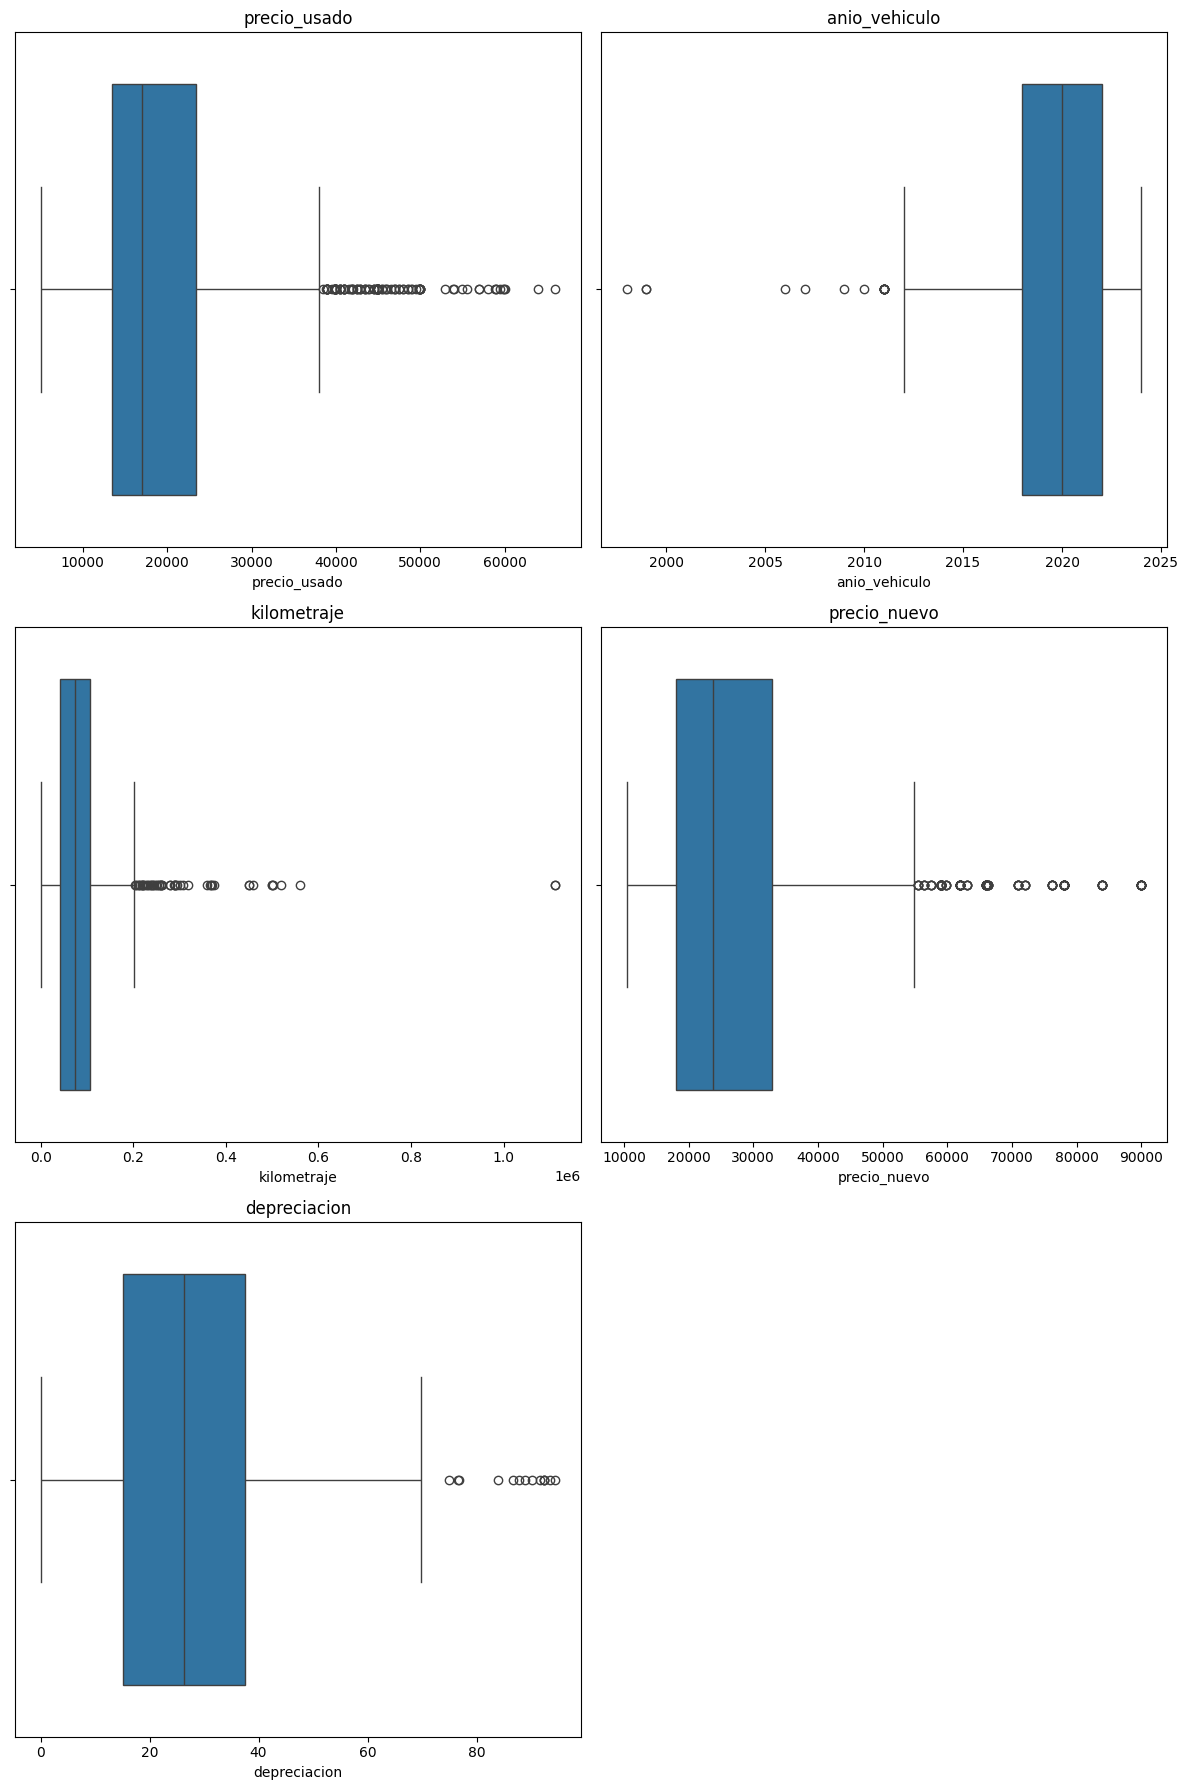

In [250]:
plot_multiple_boxplots(df_vehiculos_depreciacion, columnas_numericas_vehiculos)

In [251]:
# Rango
df_vehiculos_depreciacion.describe().loc["max"] - df_vehiculos_depreciacion.describe().loc["min"]

precio_usado     6.099000e+04
anio_vehiculo    2.600000e+01
kilometraje      1.111078e+06
puertas          3.000000e+00
id_seller        1.911393e+09
precio_nuevo     7.960000e+04
depreciacion     9.444444e+01
dtype: float64

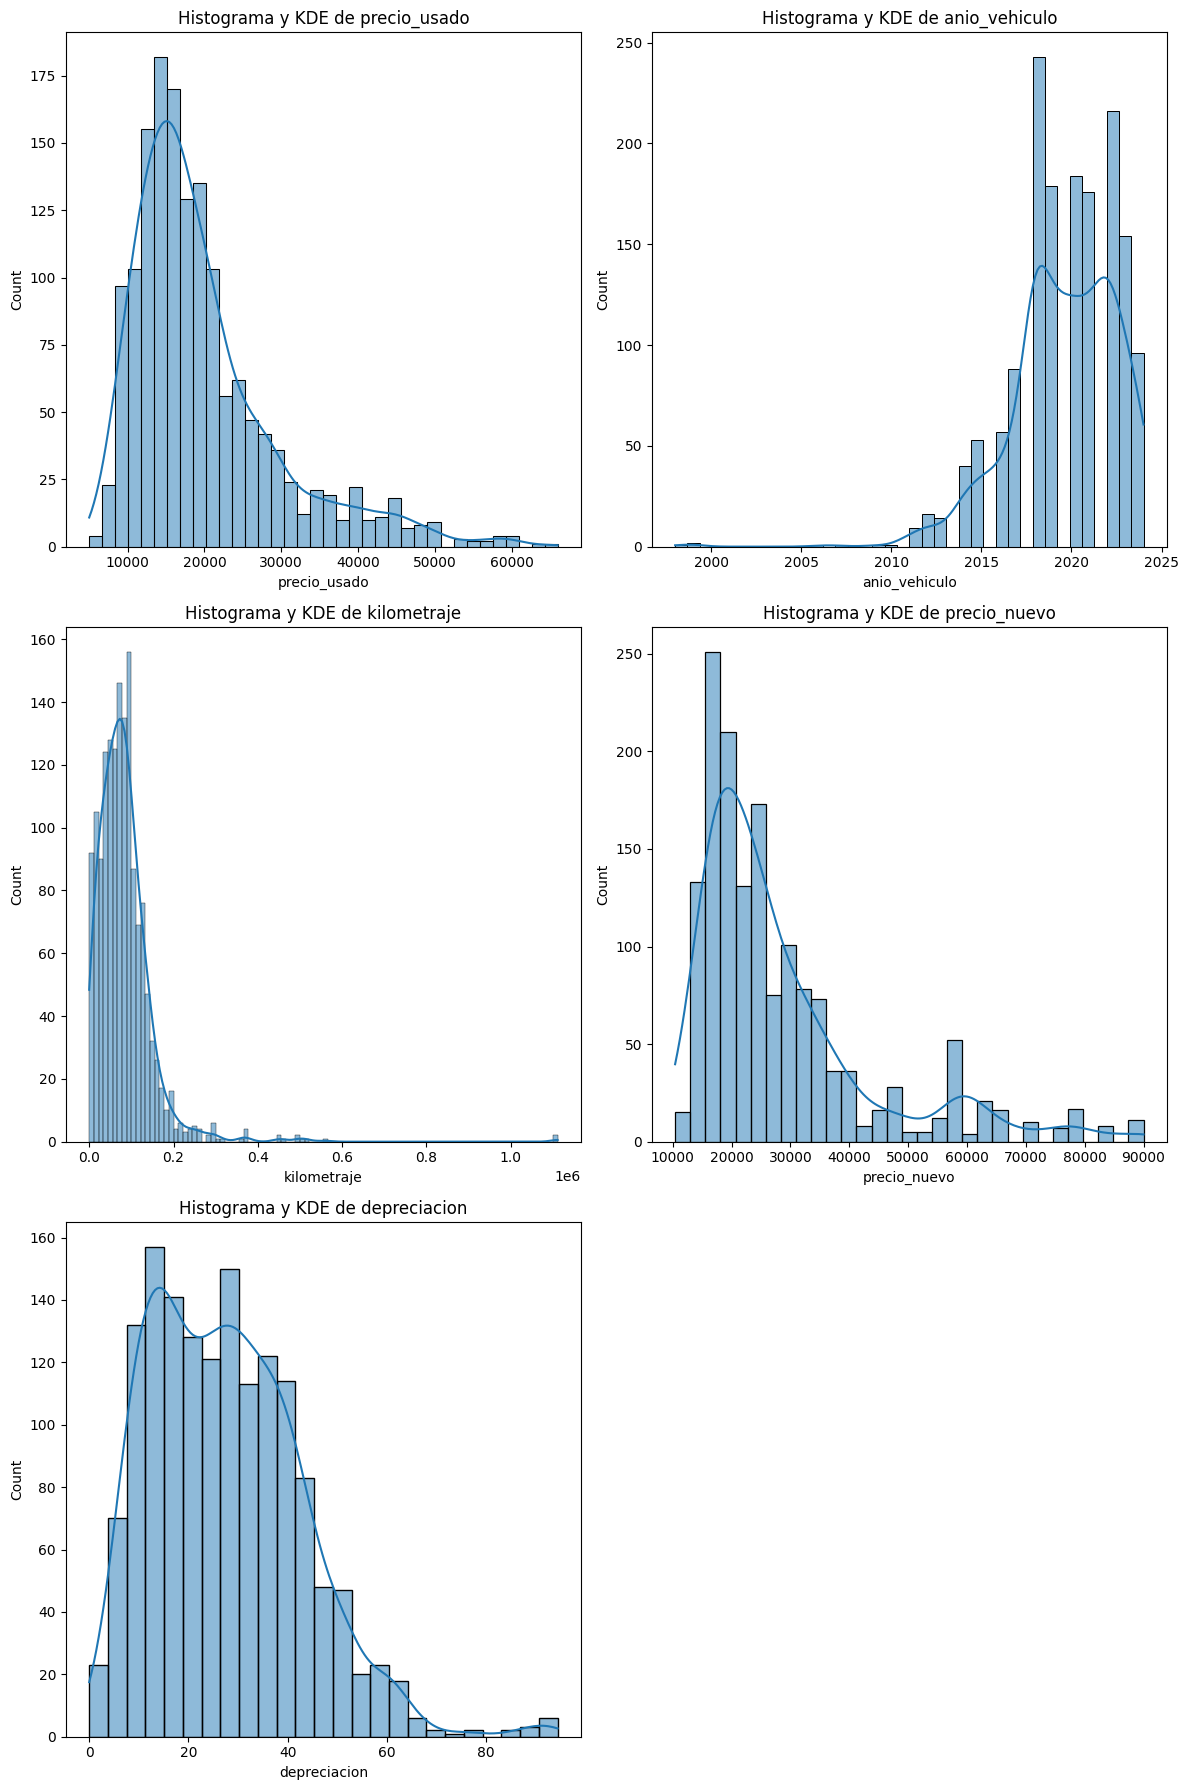

In [252]:
plot_histo_dens(df_vehiculos_depreciacion,columnas_numericas_vehiculos)

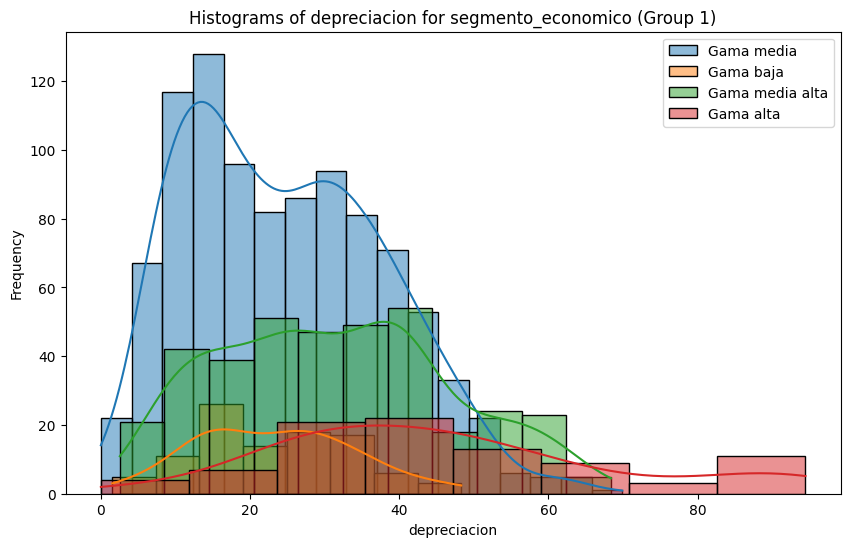

In [253]:
plot_grouped_histograms(df_vehiculos_depreciacion,"segmento_economico", "depreciacion", 4)

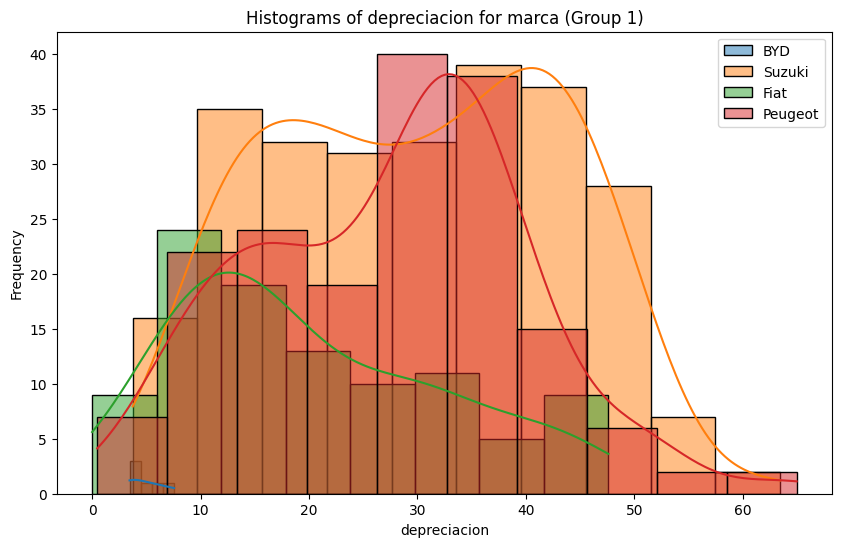

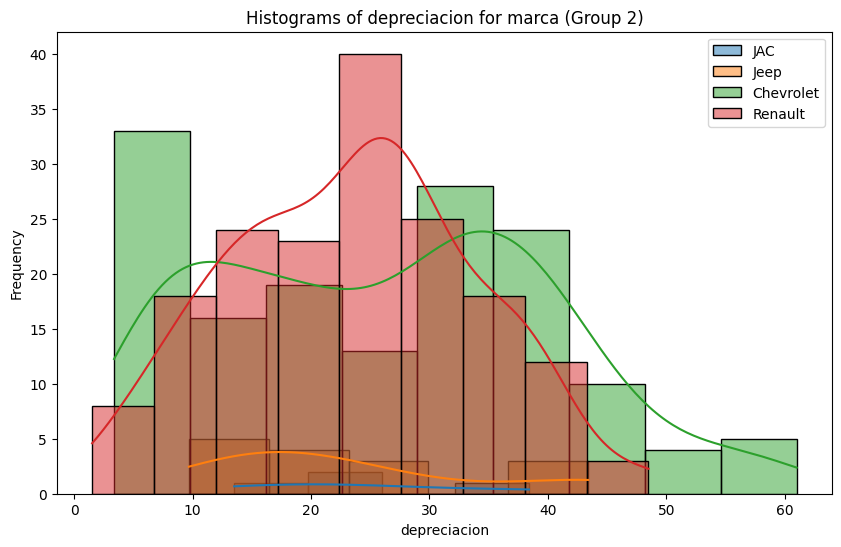

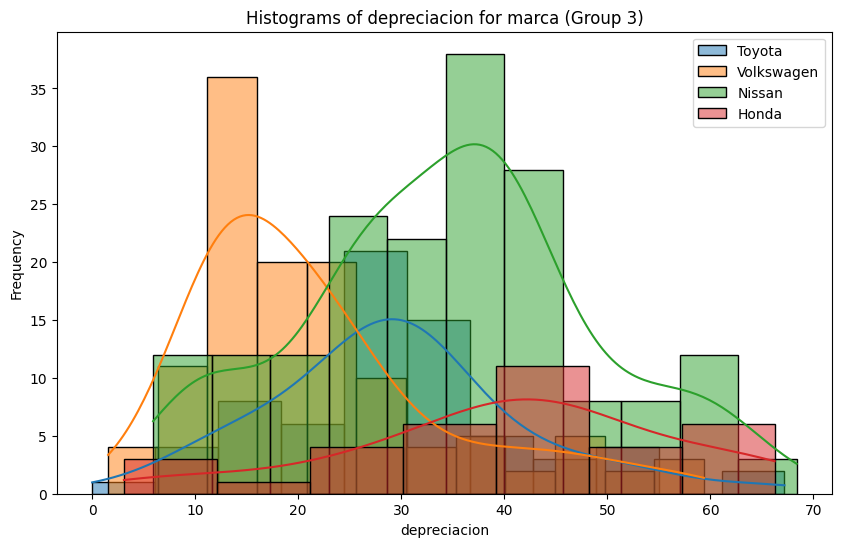

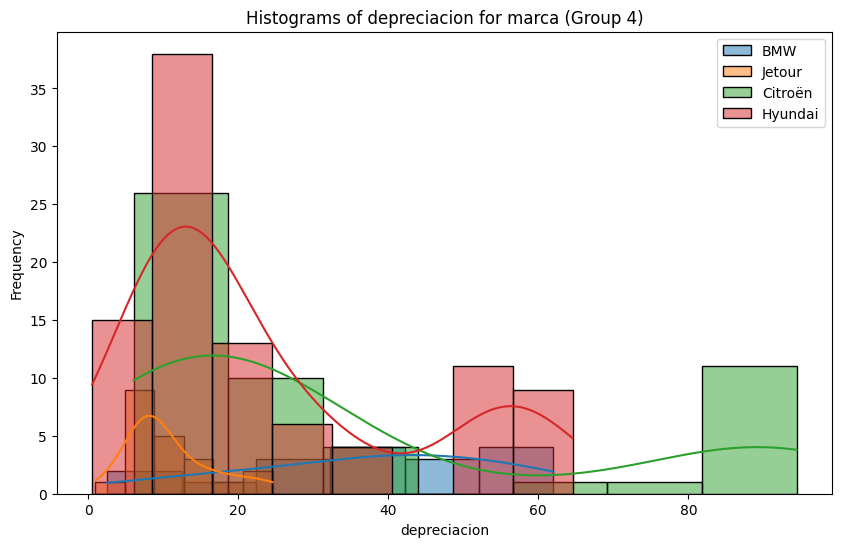

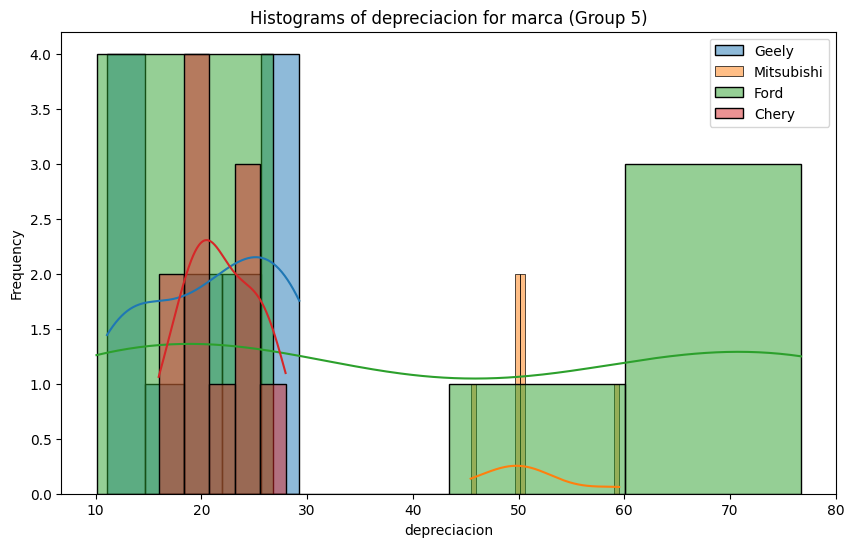

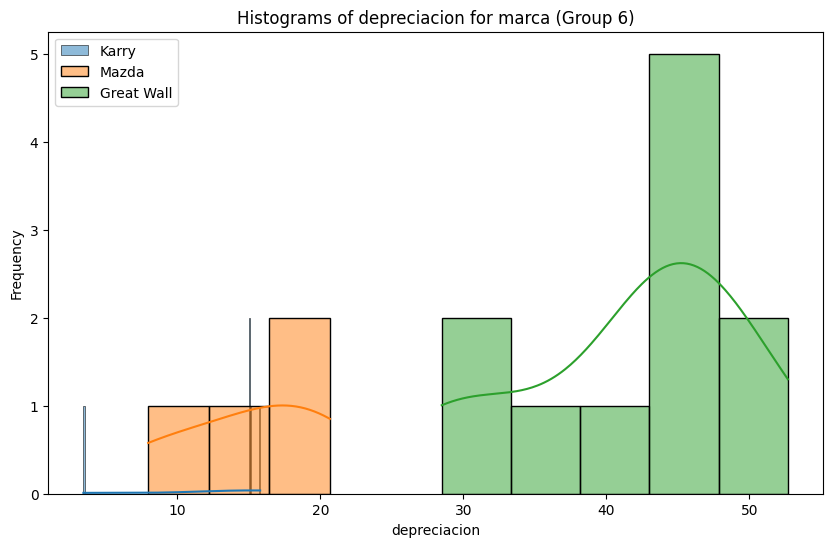

In [254]:
plot_grouped_histograms(df_vehiculos_depreciacion,"marca", "depreciacion", 4)

In [256]:
df_vehiculos_depreciacion[["precio_nuevo","depreciacion"]].corr()

,precio_nuevo,depreciacion
precio_nuevo,1.00000,0.37598
depreciacion,0.37598,1.00000


In [257]:
from scipy.stats import pearsonr

pearsonr(df_vehiculos_depreciacion["precio_nuevo"], df_vehiculos_depreciacion["depreciacion"], alternative= "less")

PearsonRResult(statistic=0.3759798263402472, pvalue=1.0)

In [258]:
df_vehiculos_depreciacion.to_csv('data/vehiculos_uy_depreciacion.csv', index=True)

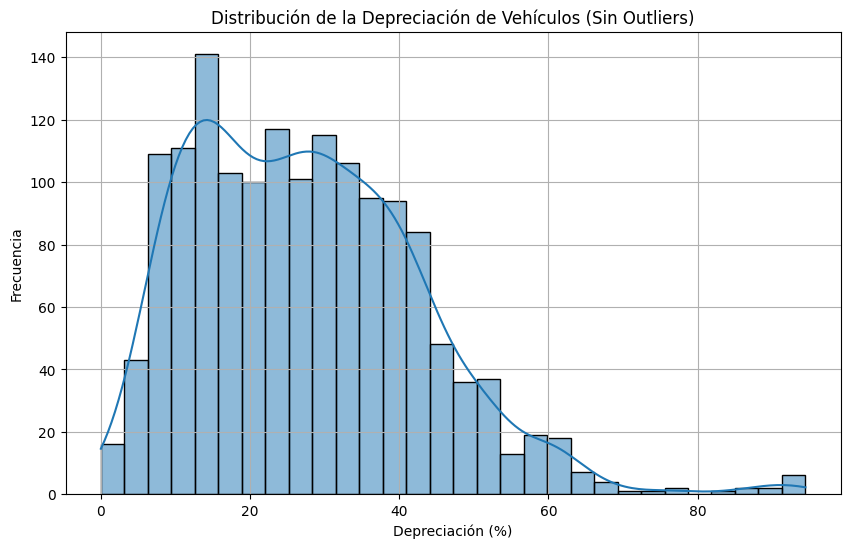

In [260]:
# Filtrando las columnas relevantes para este análisis
relevant_columns = [
    'marca', 'modelo', 'anio_vehiculo', 'precio_usado', 'precio_nuevo', 
    'condicion', 'cat_kilometros', 'segmento_economico', 'depreciacion', 
    'tipo_anuncio', 'fecha_baja_publicacion', 'tipo_combustible', 'kilometraje',
    'transmision'
]

df = df_vehiculos_depreciacion[relevant_columns]

# Gráfica de distribución de la depreciación sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(df['depreciacion'], bins=30, kde=True)
plt.title('Distribución de la Depreciación de Vehículos (Sin Outliers)')
plt.xlabel('Depreciación (%)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


In [261]:
df_vehiculos_depreciacion.loc[df_vehiculos_depreciacion['depreciacion'] > 60]

,id,titulo,moneda,precio_usado,marca,modelo,version,condicion,anio_vehiculo,kilometraje,...,tienda_oficial,id_seller,nickname,fecha_baja_publicacion,tipo_anuncio,enlace_publicacion,cat_kilometros,segmento_economico,precio_nuevo,depreciacion
41,MLU687402696,Suzuki Celerio 2016 1.0 Ga 5p,USD,6500.0,Suzuki,Celerio,1.0 Ga 5p,Usado,2016,87600,...,Tienda no oficial,176596942,DANIBANK,2024-08-17T04:00:09.195Z,gold_premium,https://auto.mercadolibre.com.uy/MLU-687402696...,Moderado kilometraje,Gama media,17790.000000,63.462619
176,MLU685896720,Suzuki Celerio 2011 1.0 Ga 5p,USD,7000.0,Suzuki,Celerio,1.0 Ga 5p,Usado,2011,180000,...,Tienda no oficial,231177961,ACLU7550339,2024-08-03T04:00:00.000Z,free,https://auto.mercadolibre.com.uy/MLU-685896720...,Mucho kilometraje,Gama media,17790.000000,60.652052
245,MLU685727500,Peugeot Partner 1.4 1998 Buen Estado! - Barriola,USD,5950.0,Peugeot,Partner,-,Usado,1998,255000,...,Barriola,66704541,AUTOMOTORA BARRIOLA,2024-10-31T04:00:00.000Z,gold_premium,https://auto.mercadolibre.com.uy/MLU-685727500...,Excesivo kilometraje,Gama media,16990.000000,64.979400
486,MLU679566492,Ford Ranger Xlt 2.5 2014 Muy Buen Estado! - So...,USD,16900.0,Ford,Ranger,Xlt,Usado,2014,154000,...,Tienda no oficial,132955553,SOLYCARAUTOMOVILES,2024-09-07T04:00:00.000Z,silver,https://auto.mercadolibre.com.uy/MLU-679566492...,Bastante kilometraje,Gama alta,71990.000000,76.524517
487,MLU681488186,Ford Ranger Xlt 2.8 2006 Impecable!,USD,16750.0,Ford,Ranger,Xlt,Usado,2006,374000,...,Tienda no oficial,69911467,RIVEROAUTOMOTORES TACUAREMBÓ,2024-10-04T04:39:26.037Z,silver,https://auto.mercadolibre.com.uy/MLU-681488186...,Excesivo kilometraje,Gama alta,71990.000000,76.732880
490,MLU684036424,Ford Ranger Xlt,USD,17990.0,Ford,Ranger,Xlt,Usado,2012,146000,...,Tienda no oficial,153864165,JMCHRYSLER2014,2024-07-24T04:00:00.000Z,free,https://auto.mercadolibre.com.uy/MLU-684036424...,Bastante kilometraje,Gama alta,71990.000000,75.010418
500,MLU686419176,Bmw 120i Pack M,USD,31900.0,BMW,Serie 2,2.0 220i Sport Line 184cv,Usado,2016,120000,...,Tienda no oficial,277468025,CARA3897843,2024-08-09T04:00:00.000Z,gold_premium,https://auto.mercadolibre.com.uy/MLU-686419176...,Bastante kilometraje,Gama alta,83990.000000,62.019288
512,MLU687477066,Hyundai Ioniq 1.6 Hibrido At 5p 2018,USD,22900.0,Hyundai,Ioniq,1.6 Gdi Hibrido At 5p,Usado,2018,67457,...,Shopping de Autos,164934290,SHOPPINGDEAUTOS,2025-07-22T04:00:00.000Z,gold_premium,https://auto.mercadolibre.com.uy/MLU-687477066...,Moderado kilometraje,Gama media alta,58990.000000,61.179861
513,MLU687451134,Hyundai Ioniq 1.6 Hibrido At 5p 2018,USD,22900.0,Hyundai,Ioniq,1.6 Gdi Hibrido At 5p,Usado,2018,67457,...,Shopping de Autos,164934290,SHOPPINGDEAUTOS,2025-07-22T04:00:00.000Z,gold_premium,https://auto.mercadolibre.com.uy/MLU-687451134...,Moderado kilometraje,Gama media alta,58990.000000,61.179861
526,MLU678123534,Hyundai Ioniq,USD,20890.0,Hyundai,Ioniq,1.6 Gdi Hibrido At 5p,Usado,2018,102926,...,Usados Fidocar,1198841881,USADOS FIDOCAR,2024-08-25T04:00:00.000Z,gold_premium,https://auto.mercadolibre.com.uy/MLU-678123534...,Bastante kilometraje,Gama media alta,58990.000000,64.587218


## ¿Cómo se distribuye la depreciación de los vehículos? 


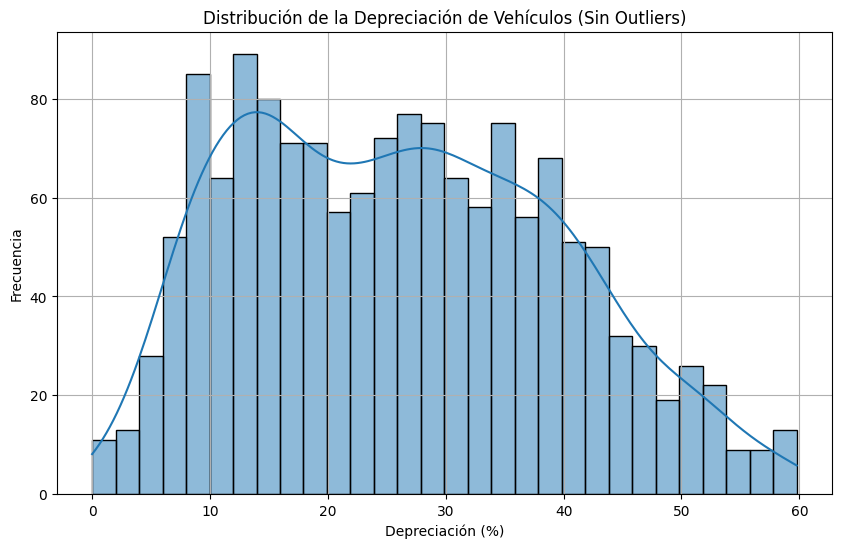

In [262]:
# Del análisis de el listado de publicaciones con depreciación > 60, observo que corresponden a errores en la publicación.
# Tomo la decisión de filtrar esos datos para que no contaminen el análisis

# Filtrando las columnas relevantes para este análisis

df = df_vehiculos_depreciacion[relevant_columns]

# Filtrar los datos para eliminar registros con depreciación mayor a 60%
df_filtered = df[df['depreciacion'] <= 60]

# Gráfica de distribución de la depreciación sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['depreciacion'], bins=30, kde=True)
plt.title('Distribución de la Depreciación de Vehículos (Sin Outliers)')
plt.xlabel('Depreciación (%)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()




In [263]:
df_filtered.depreciacion.describe()

count    1488.000000
mean       26.183737
std        13.471622
min         0.000000
25%        14.891760
50%        25.335570
75%        36.271595
max        59.773829
Name: depreciacion, dtype: float64

## ¿La transmisión del vehículo influye en la depreciación?

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/674821412.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='transmision', y='depreciacion', data=df_filtered_trans, palette="viridis")


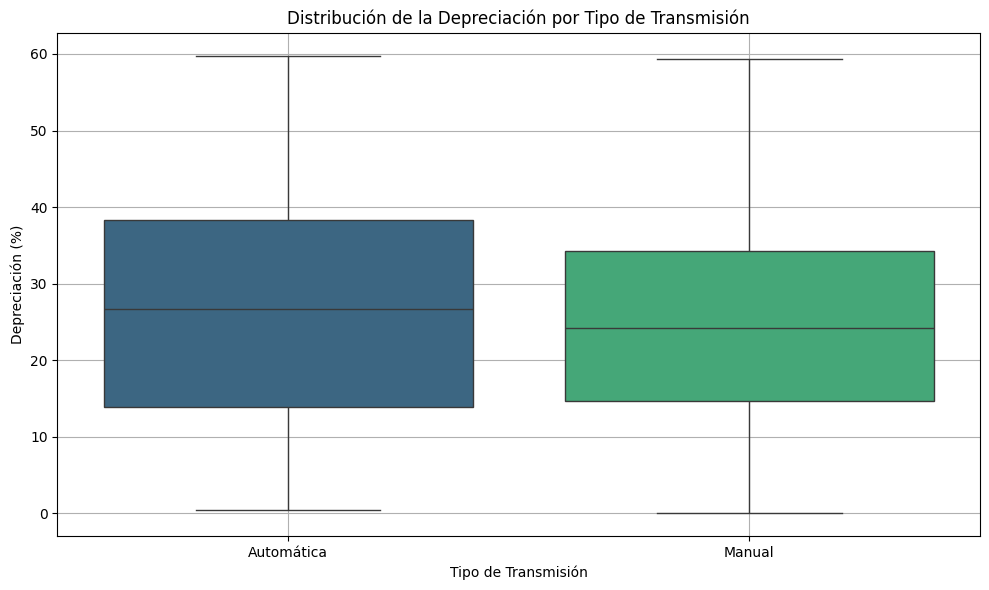

In [281]:
# Filtrar los datos para excluir las transmisiones no especificadas
df_filtered_trans = df_filtered[df_filtered['transmision'] != 'transmision_no_especificado']

# Crear un diagrama de dispersión entre tipo de transmisión y depreciación
plt.figure(figsize=(10, 6))
sns.boxplot(x='transmision', y='depreciacion', data=df_filtered_trans, palette="viridis")
plt.title('Distribución de la Depreciación por Tipo de Transmisión')
plt.xlabel('Tipo de Transmisión')
plt.ylabel('Depreciación (%)')
plt.grid(True)
plt.tight_layout()
plt.show()



## ¿La elección de combustible afecta cuánto pierde de valor tu coche? ¿Deberías considerar un cambio a vehículos eléctricos o híbridos?

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/4268271681.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='depreciacion', y='tipo_combustible', data=depreciacion_por_combustible, palette="viridis", ax=axes[0])
/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/4268271681.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depreciacion', y='tipo_combustible', data=df_filtered, order=depreciacion_por_combustible['tipo_combustible'], palette="viridis", ax=axes[1])


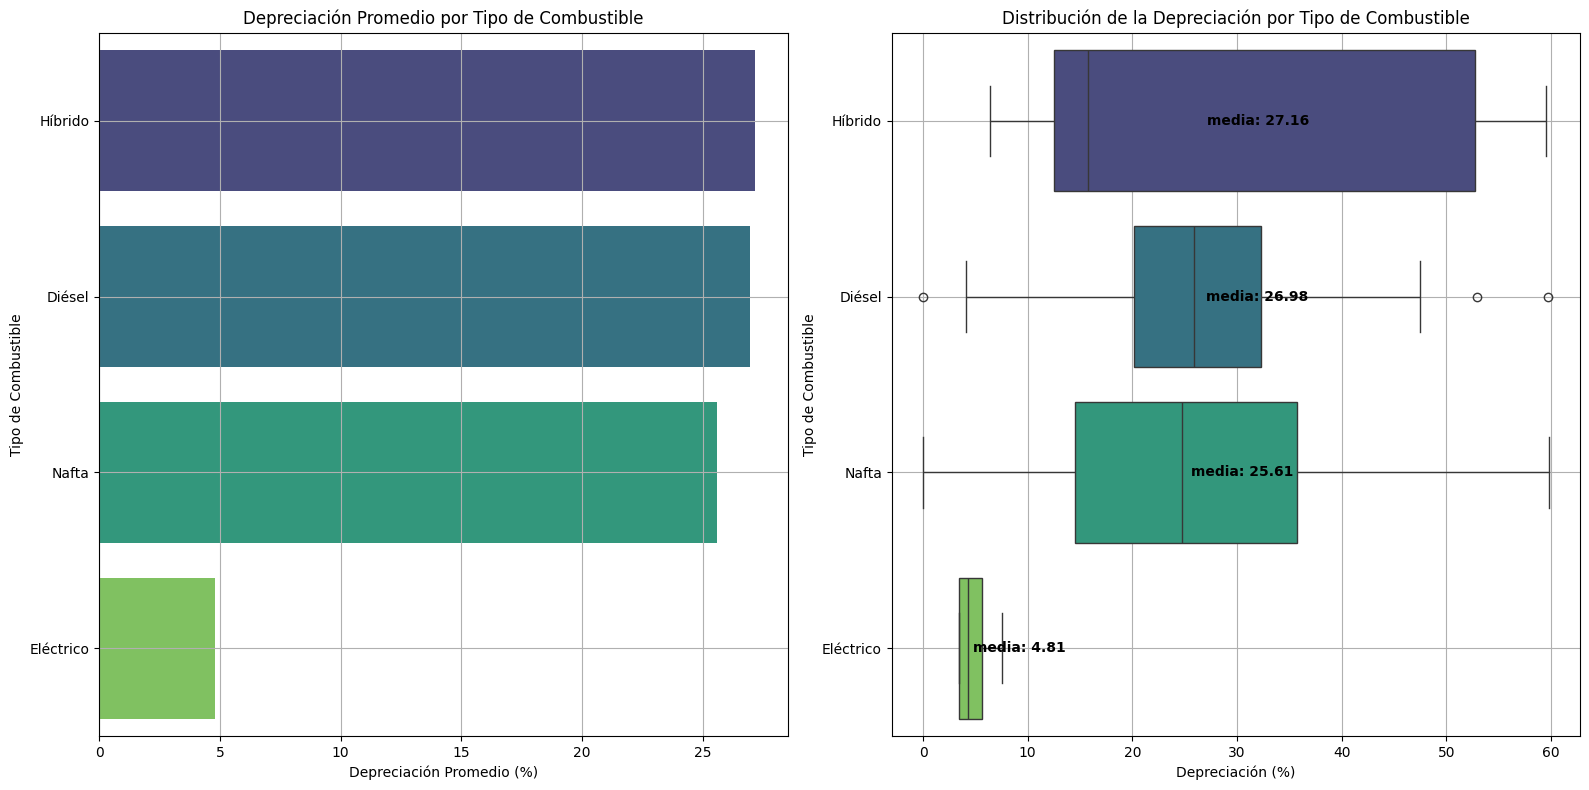

In [282]:
# Calcular la depreciación promedio por tipo de combustible
depreciacion_por_combustible = df_filtered.groupby('tipo_combustible')['depreciacion'].mean().reset_index()
depreciacion_por_combustible = depreciacion_por_combustible.sort_values(by='depreciacion', ascending=False)

# Crear la figura con dos columnas y una fila
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de barras
sns.barplot(x='depreciacion', y='tipo_combustible', data=depreciacion_por_combustible, palette="viridis", ax=axes[0])
axes[0].set_title('Depreciación Promedio por Tipo de Combustible')
axes[0].set_xlabel('Depreciación Promedio (%)')
axes[0].set_ylabel('Tipo de Combustible')
axes[0].grid(True)

# Gráfico de caja y bigote
sns.boxplot(x='depreciacion', y='tipo_combustible', data=df_filtered, order=depreciacion_por_combustible['tipo_combustible'], palette="viridis", ax=axes[1])
axes[1].set_title('Distribución de la Depreciación por Tipo de Combustible')
axes[1].set_xlabel('Depreciación (%)')
axes[1].set_ylabel('Tipo de Combustible')
axes[1].grid(True)

# Añadir etiquetas de promedio general en el gráfico de caja y bigote
for i, combustible in enumerate(depreciacion_por_combustible['tipo_combustible']):
    media = depreciacion_por_combustible[depreciacion_por_combustible['tipo_combustible'] == combustible]['depreciacion'].values[0]
    axes[1].text(media, i, f'media: {media:.2f}', va='center', ha='left', color='black', fontweight='bold')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

## ¿Cuántos kilómetros son demasiados? ¿El kilometraje realmente afecta el valor de reventa de un vehículo?

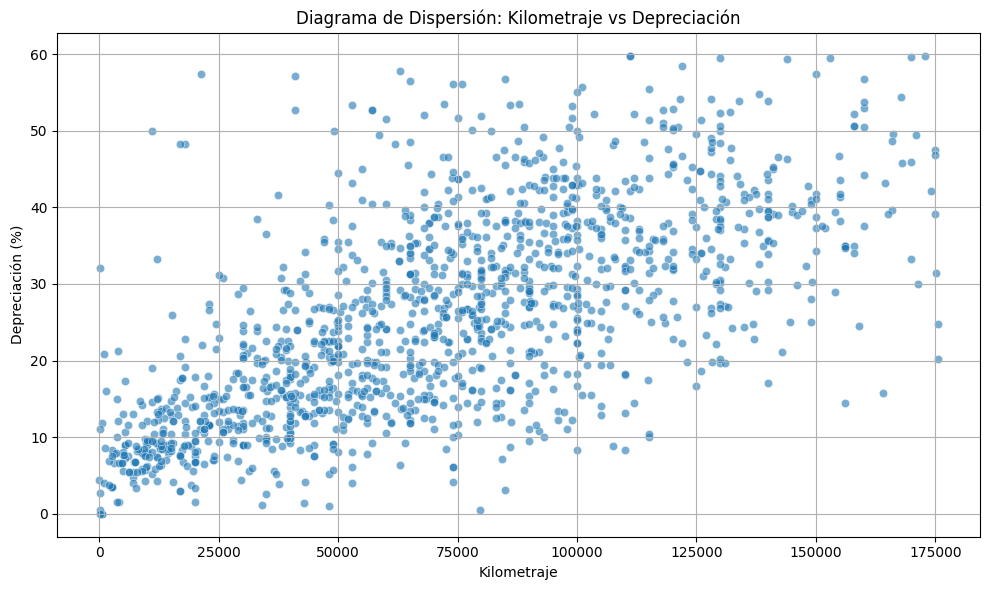

p-value: 9.730768694179697e-190, R-squared: 0.4530658031971056


In [283]:
# Crear un diagrama de dispersión entre kilometraje y depreciación
plt.figure(figsize=(10, 6))
sns.scatterplot(x='kilometraje', y='depreciacion', data=df_filtered, alpha=0.6)
plt.title('Diagrama de Dispersión: Kilometraje vs Depreciación')
plt.xlabel('Kilometraje')
plt.ylabel('Depreciación (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis estadístico: cálculo del p-valor para la relación entre kilometraje y depreciación
slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered['kilometraje'], df_filtered['depreciacion'])

# Mostrar los resultados del análisis
print(f"p-value: {p_value}, R-squared: {r_value ** 2}")

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/481996766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cat_kilometros'] = pd.Categorical(


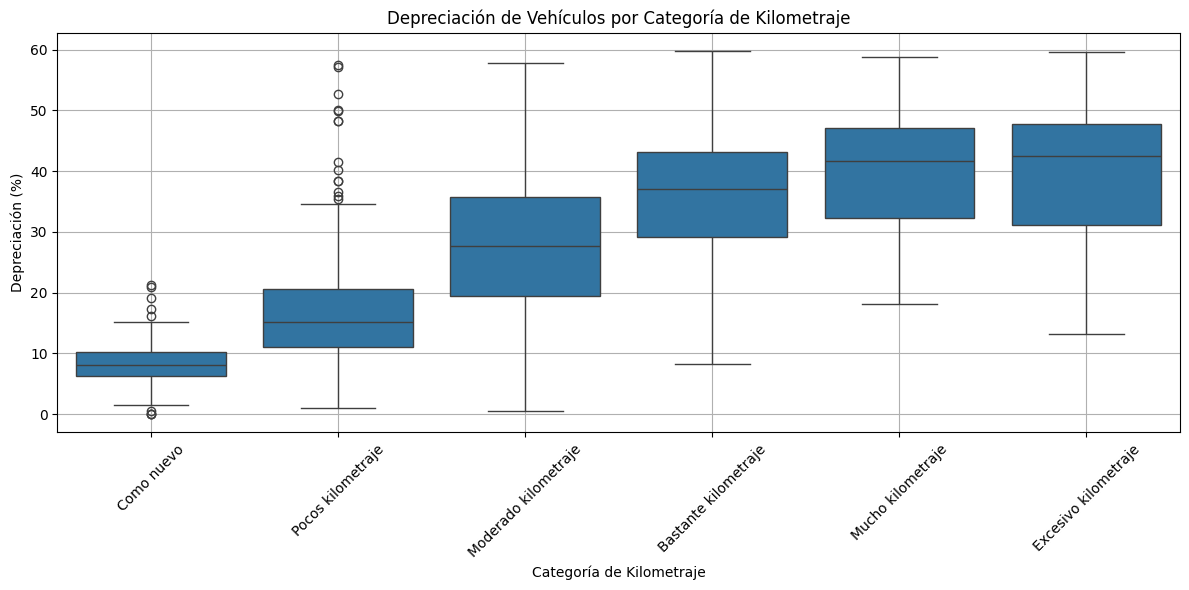

In [264]:
df_filtered['cat_kilometros'] = pd.Categorical(
    df_filtered['cat_kilometros'], 
    categories=[
        'Como nuevo', 'Pocos kilometraje', 'Moderado kilometraje', 
        'Bastante kilometraje', 'Mucho kilometraje', 'Excesivo kilometraje', 
    ],
    ordered=True
)

# Gráfica de depreciación promedio por categoría de kilometraje
plt.figure(figsize=(12, 6))
sns.boxplot(x='cat_kilometros', y='depreciacion', data=df_filtered)
plt.title('Depreciación de Vehículos por Categoría de Kilometraje')
plt.xlabel('Categoría de Kilometraje')
plt.ylabel('Depreciación (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [265]:
df_filtered.kilometraje.info()

<class 'pandas.core.series.Series'>
Index: 1488 entries, 0 to 1531
Series name: kilometraje
Non-Null Count  Dtype
--------------  -----
1488 non-null   int64
dtypes: int64(1)
memory usage: 23.2 KB


- Como nuevo: Los vehículos en esta categoría muestran una depreciación relativamente baja, lo cual es esperado ya que el kilometraje es un factor crucial en la valoración de un vehículo usado.
- Pocos kilometraje: La depreciación aumenta ligeramente en comparación con “Como nuevo”, pero sigue siendo relativamente baja.
- Moderado kilometraje: Hay una mayor variabilidad en la depreciación, pero en promedio, la depreciación sigue siendo moderada.
- Bastante kilometraje: A partir de esta categoría, la depreciación muestra una tendencia clara a aumentar.
- Mucho kilometraje: La depreciación es notablemente más alta, indicando que los vehículos con mucho kilometraje pierden más valor.
- Excesivo kilometraje: Esta categoría tiene la mayor variabilidad y los valores más altos de depreciación, lo que refuerza la importancia del kilometraje en la devaluación del vehículo.

Desde el punto de vista de la correlación: La correlación entre kilometraje y depreciación es de aproximadamente 0.60, lo que indica una relación moderadamente fuerte. Esto sugiere que el kilometraje es un buen indicador de la depreciación del valor del vehículo.

El kilometraje es un factor importante en la depreciación de los vehículos. A medida que aumenta el kilometraje, también lo hace la depreciación, especialmente notable a partir de “Bastante kilometraje”. Los vehículos con “Excesivo kilometraje” presentan la mayor depreciación, lo que puede influir significativamente en la decisión de compra.



## Pero entonces, ¿cuál es la mejor estrategia de compra y venta con el menor impacto en la depreciación?

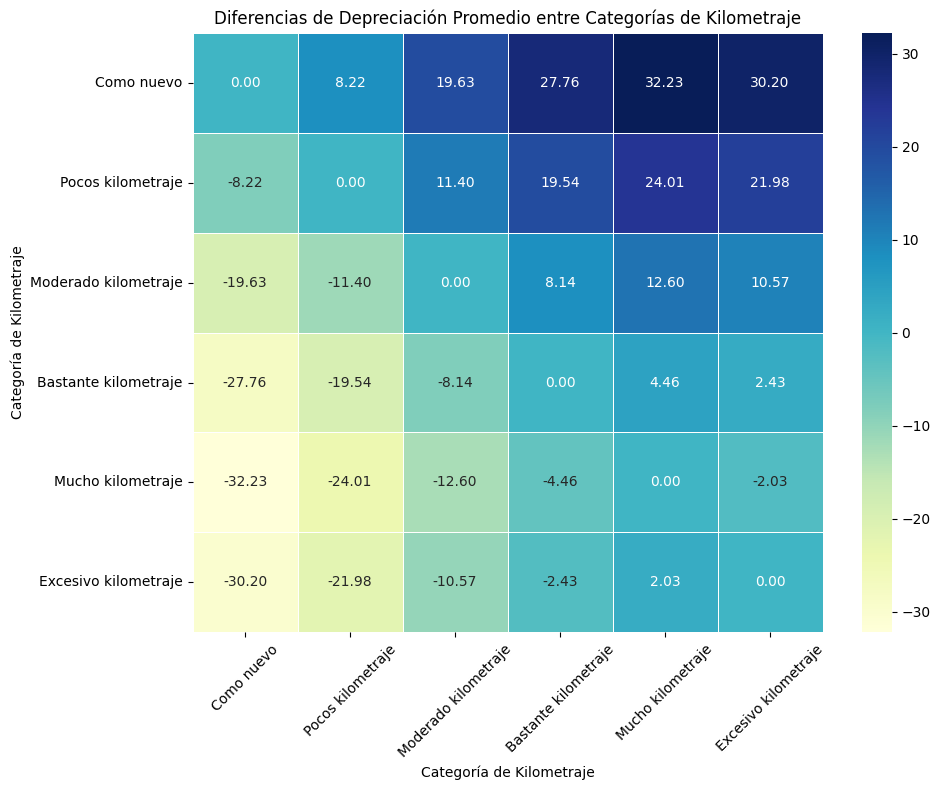

In [267]:
categorias = df_filtered['cat_kilometros'].cat.categories
depreciacion_matrix = pd.DataFrame(index=categorias, columns=categorias)

# Rellenar la matriz con las diferencias promedio de depreciación entre categorías
for i in range(len(categorias)):
    for j in range(len(categorias)):
        if i != j:
            media_i = df_filtered[df_filtered['cat_kilometros'] == categorias[i]]['depreciacion'].mean()
            media_j = df_filtered[df_filtered['cat_kilometros'] == categorias[j]]['depreciacion'].mean()
            depreciacion_matrix.iloc[i, j] = media_j - media_i
        else:
            depreciacion_matrix.iloc[i, j] = 0

depreciacion_matrix

# Crear un mapa de calor para visualizar la depreciación entre categorías de kilometraje
plt.figure(figsize=(10, 8))
sns.heatmap(depreciacion_matrix.astype(float), annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title('Diferencias de Depreciación Promedio entre Categorías de Kilometraje')
plt.xlabel('Categoría de Kilometraje')
plt.ylabel('Categoría de Kilometraje')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## ¿Cuáles son las marcas y modelos que mejor retienen su valor? ¿Hay alguna marca en la que puedas confiar para mantener tu inversión?

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/3279220477.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depreciacion', y='marca', data=df_top_marcas, order=depreciacion_promedio_marca, palette="viridis")


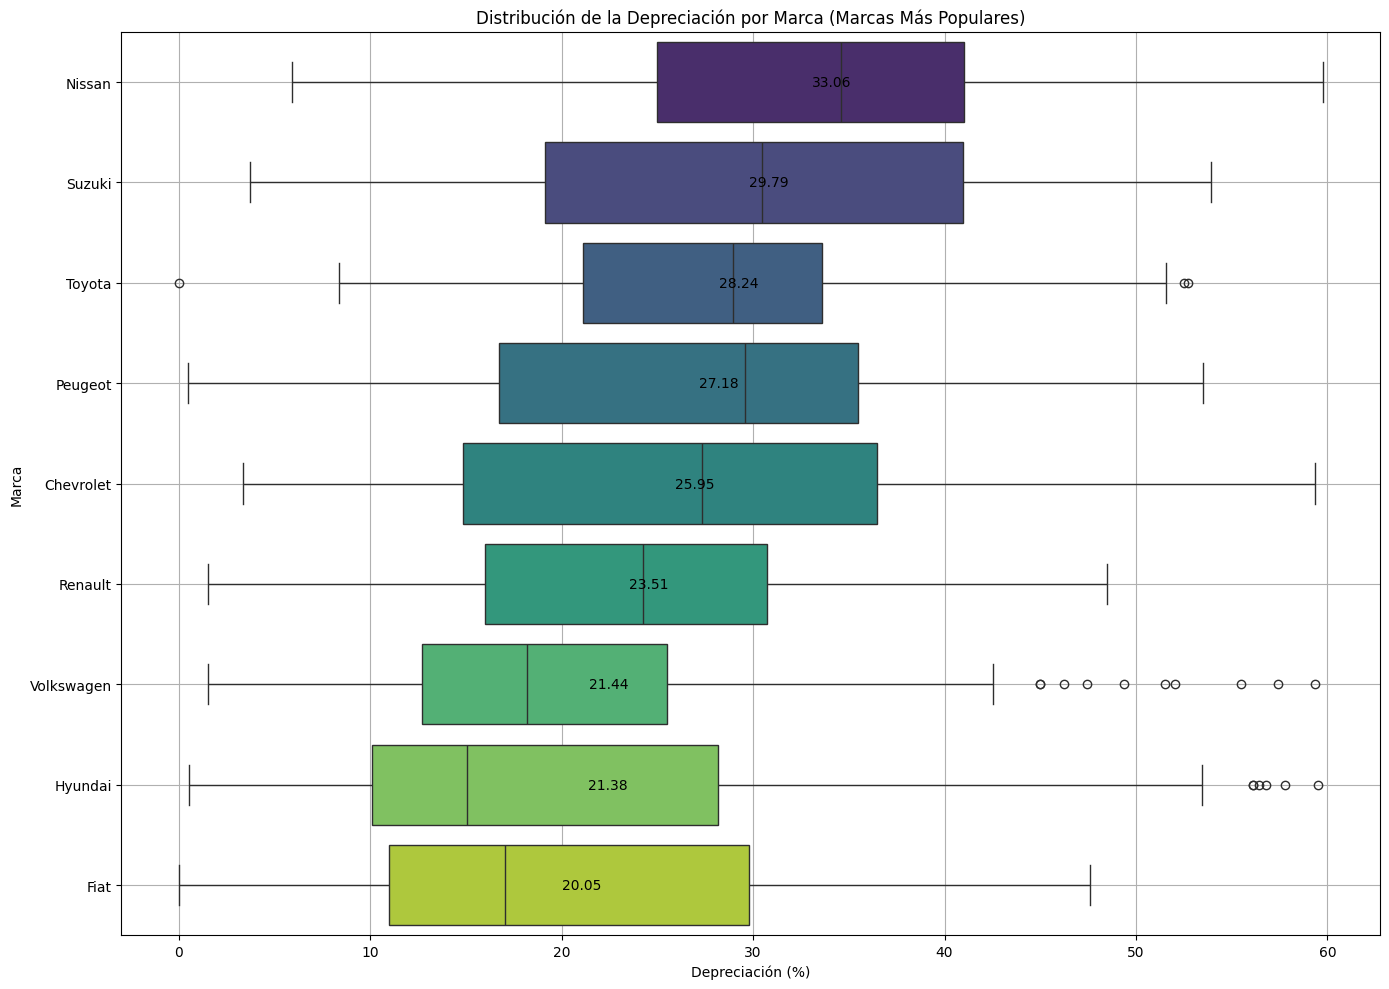

In [268]:
# Identificar las marcas más comunes en el dataset
marca_counts = df_filtered['marca'].value_counts()
top_marcas = marca_counts[marca_counts > marca_counts.mean()].index

# Filtrar el dataframe para incluir solo las marcas más comunes
df_top_marcas = df_filtered[df_filtered['marca'].isin(top_marcas)]

# Calcular la depreciación promedio por marca para ordenar
depreciacion_promedio_marca = df_top_marcas.groupby('marca')['depreciacion'].mean().sort_values(ascending=False).index

# Crear un gráfico de caja y bigote para mostrar la distribución de la depreciación dentro de cada una de las marcas más comunes, ordenadas por depreciación promedio
plt.figure(figsize=(14, 10))
sns.boxplot(x='depreciacion', y='marca', data=df_top_marcas, order=depreciacion_promedio_marca, palette="viridis")

# Calcular y etiquetar la media de cada marca
for i, marca in enumerate(depreciacion_promedio_marca):
    media = df_top_marcas[df_top_marcas['marca'] == marca]['depreciacion'].mean()
    plt.text(media, i, f'{media:.2f}', va='center', ha='left', color='black')

plt.title('Distribución de la Depreciación por Marca (Marcas Más Populares)')
plt.xlabel('Depreciación (%)')
plt.ylabel('Marca')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/91953396.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depreciacion', y='marca', data=df_remaining_marcas, order=depreciacion_promedio_remaining_marca, palette="viridis")


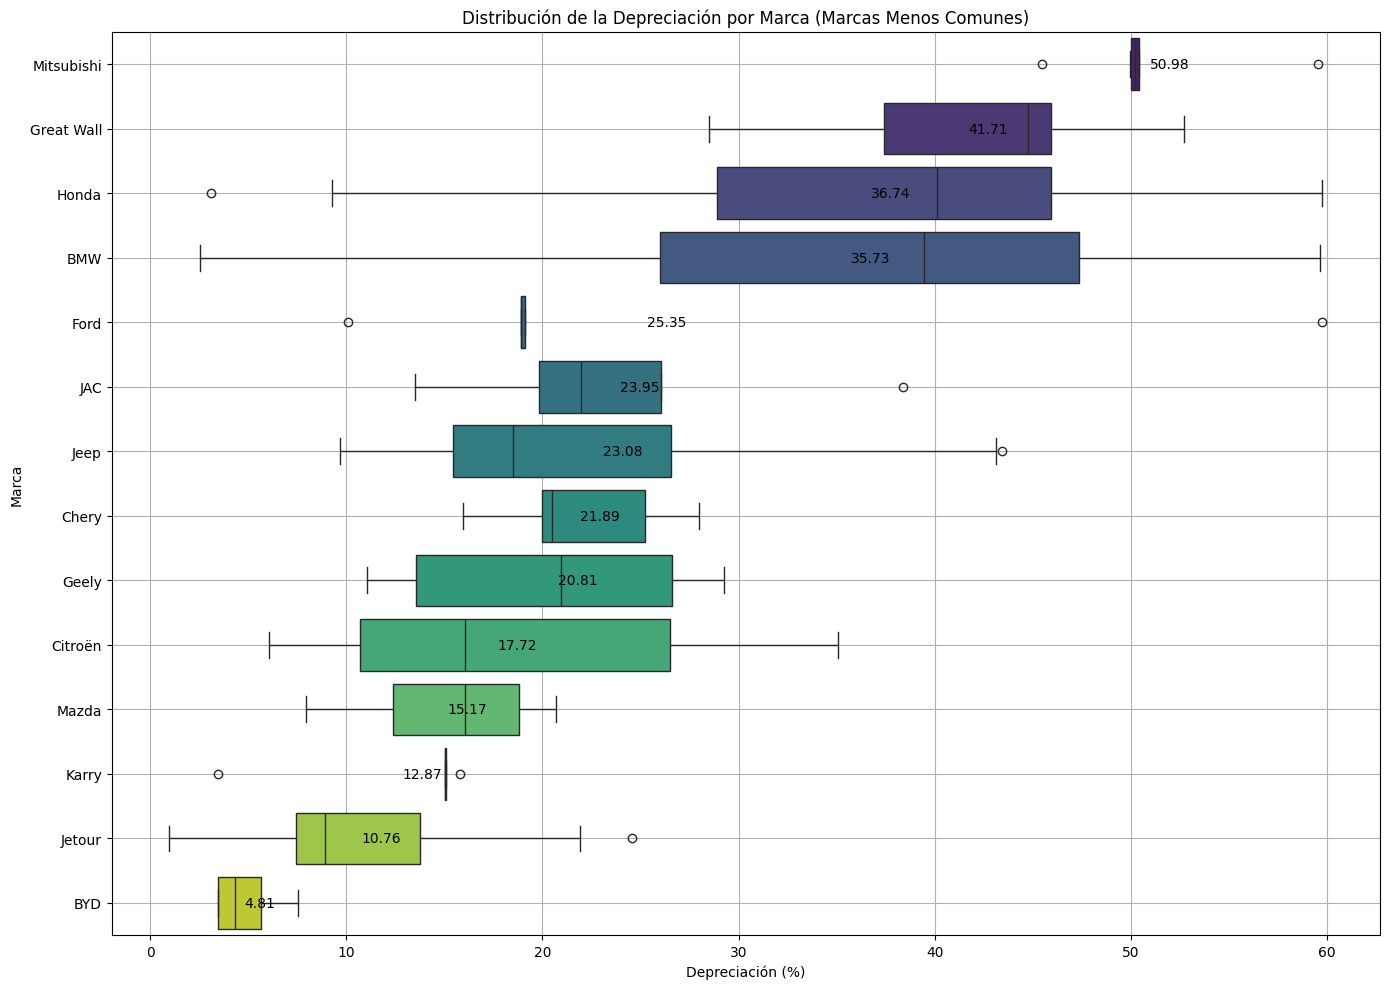

In [269]:
# Identificar las marcas menos comunes en el dataset
marca_counts = df_filtered['marca'].value_counts()
remaining_marcas = marca_counts[marca_counts <= marca_counts.mean()].index

# Filtrar el dataframe para incluir solo las marcas menos comunes
df_remaining_marcas = df_filtered[df_filtered['marca'].isin(remaining_marcas)]

# Calcular la depreciación promedio por marca para ordenar
depreciacion_promedio_remaining_marca = df_remaining_marcas.groupby('marca')['depreciacion'].mean().sort_values(ascending=False).index

# Crear un gráfico de caja y bigote para mostrar la distribución de la depreciación dentro de cada una de las marcas menos comunes, ordenadas por depreciación promedio
plt.figure(figsize=(14, 10))
sns.boxplot(x='depreciacion', y='marca', data=df_remaining_marcas, order=depreciacion_promedio_remaining_marca, palette="viridis")

# Calcular y etiquetar la media de cada marca
for i, marca in enumerate(depreciacion_promedio_remaining_marca):
    media = df_remaining_marcas[df_remaining_marcas['marca'] == marca]['depreciacion'].mean()
    plt.text(media, i, f'{media:.2f}', va='center', ha='left', color='black')

plt.title('Distribución de la Depreciación por Marca (Marcas Menos Comunes)')
plt.xlabel('Depreciación (%)')
plt.ylabel('Marca')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/2634894990.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depreciacion', y='marca', data=df_cat, order=depreciacion_promedio_cat_marca, palette="viridis")
/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/2634894990.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depreciacion', y='marca', data=df_cat, order=depreciacion_promedio_cat_marca, palette="viridis")
/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/2634894990.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=Fal

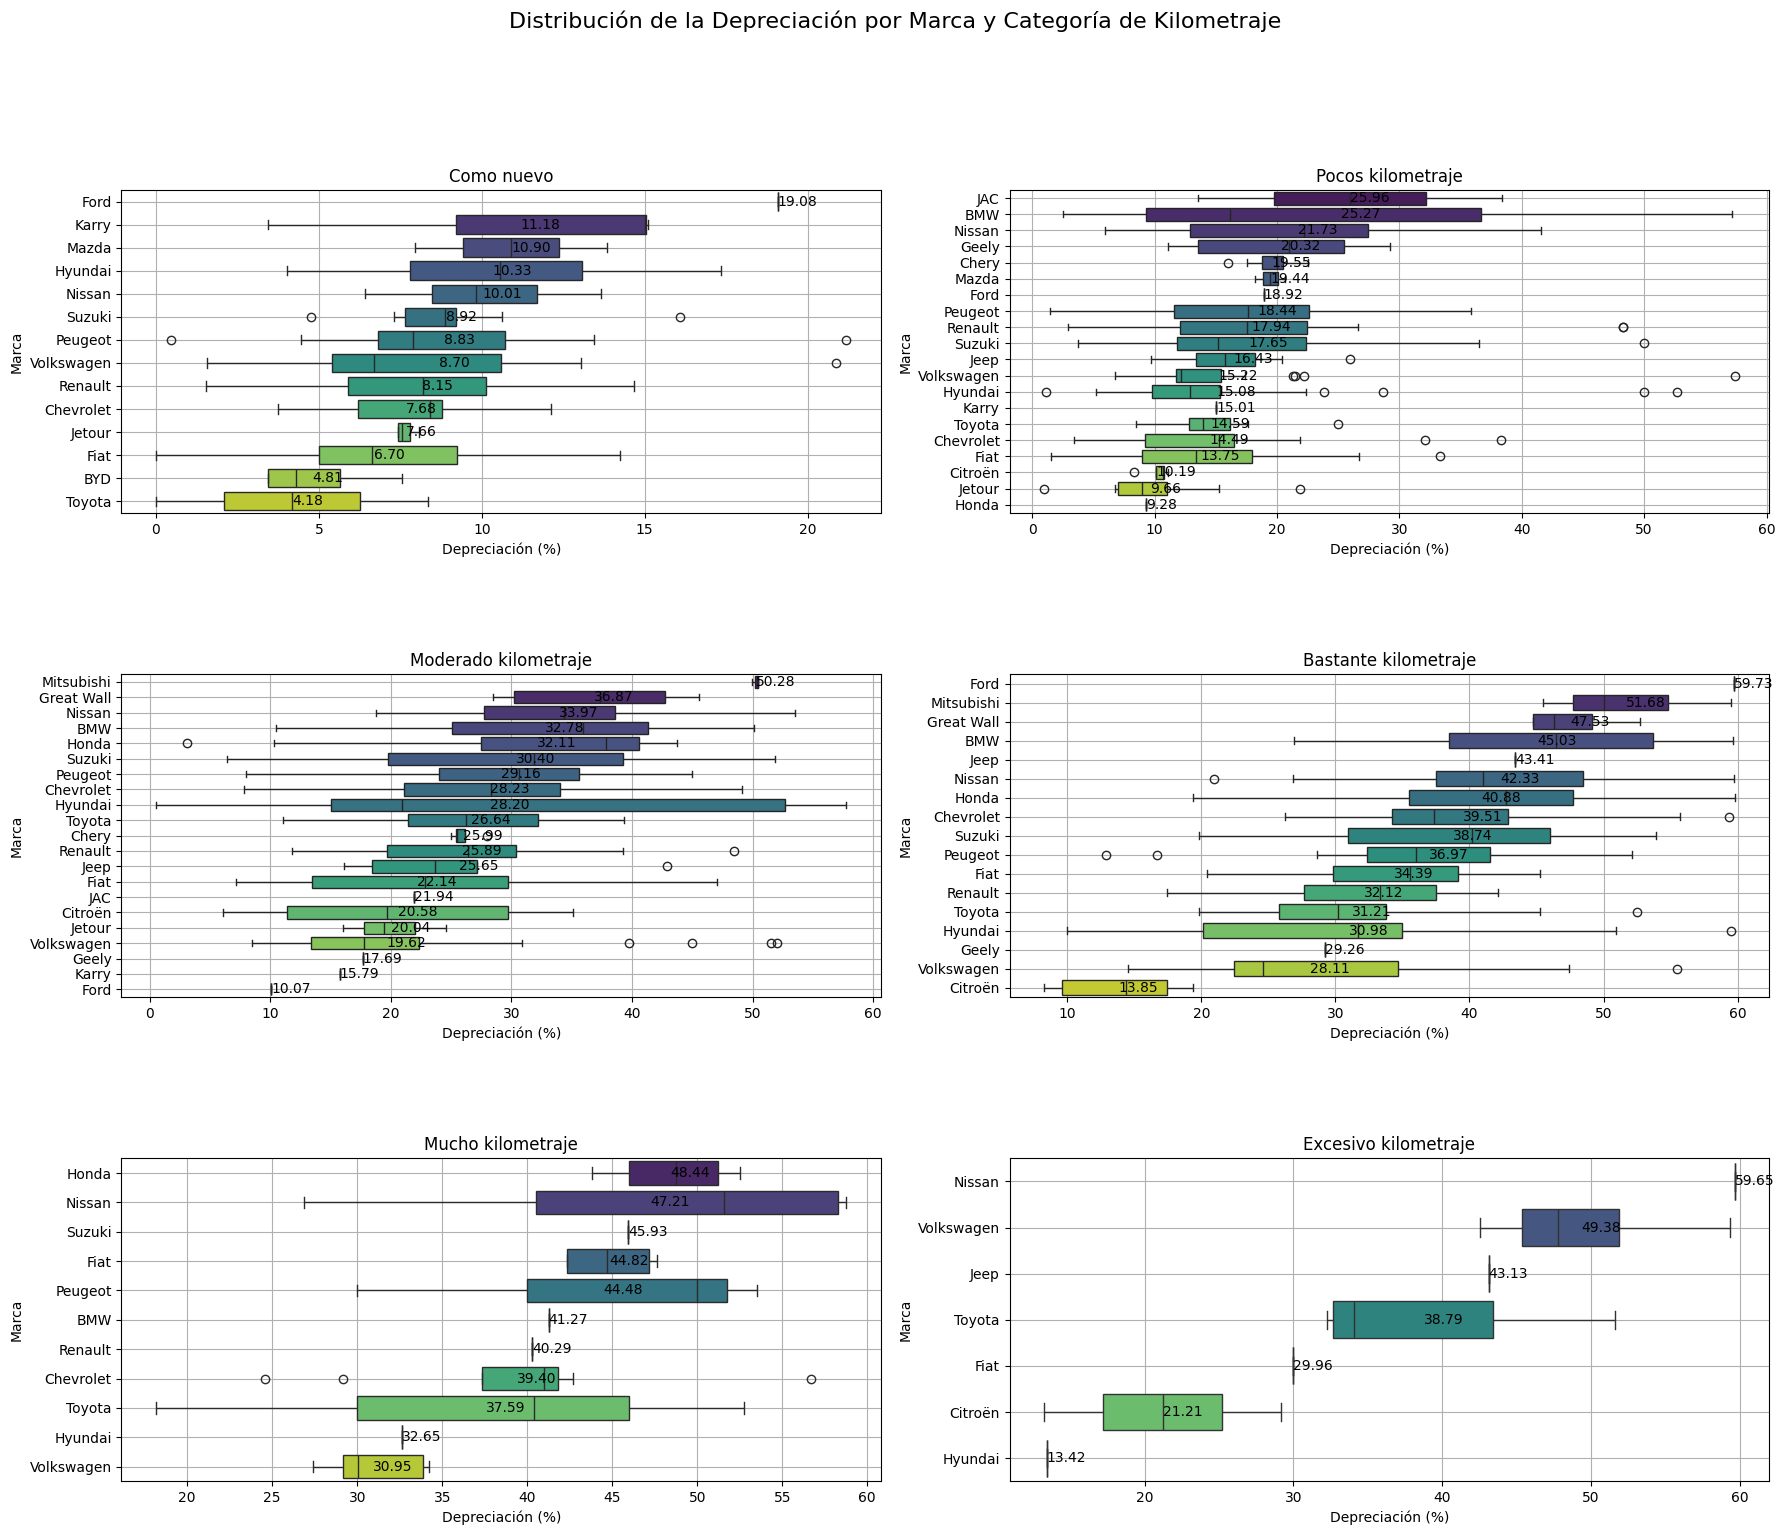

In [270]:

# Análisis de las marcas más comunes con separación por categorías de kilometraje en una misma figura
plt.figure(figsize=(18, 15))

for i, cat in enumerate(df_filtered['cat_kilometros'].cat.categories):
    # Filtrar el dataframe por la categoría de kilometraje actual
    df_cat = df_filtered[df_filtered['cat_kilometros'] == cat]
    
    # Calcular la depreciación promedio por marca dentro de esta categoría
    depreciacion_promedio_cat_marca = df_cat.groupby('marca')['depreciacion'].mean().sort_values(ascending=False).index
    
    # Crear un gráfico de caja y bigote para mostrar la distribución de la depreciación
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='depreciacion', y='marca', data=df_cat, order=depreciacion_promedio_cat_marca, palette="viridis")
    
    # Calcular y etiquetar la media de cada marca
    for j, marca in enumerate(depreciacion_promedio_cat_marca):
        media = df_cat[df_cat['marca'] == marca]['depreciacion'].mean()
        plt.text(media, j, f'{media:.2f}', va='center', ha='left', color='black')

    plt.title(f'{cat}')
    plt.xlabel('Depreciación (%)')
    plt.ylabel('Marca')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Distribución de la Depreciación por Marca y Categoría de Kilometraje', y=1.02, fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/950862834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cat_kilometros'] = pd.Categorical(
/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/950862834.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depreciacion', y='marca', data=df_cat_top, order=depreciacion_promedio_top_marca, palette="viridis", ax=ax)
/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/950862834.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

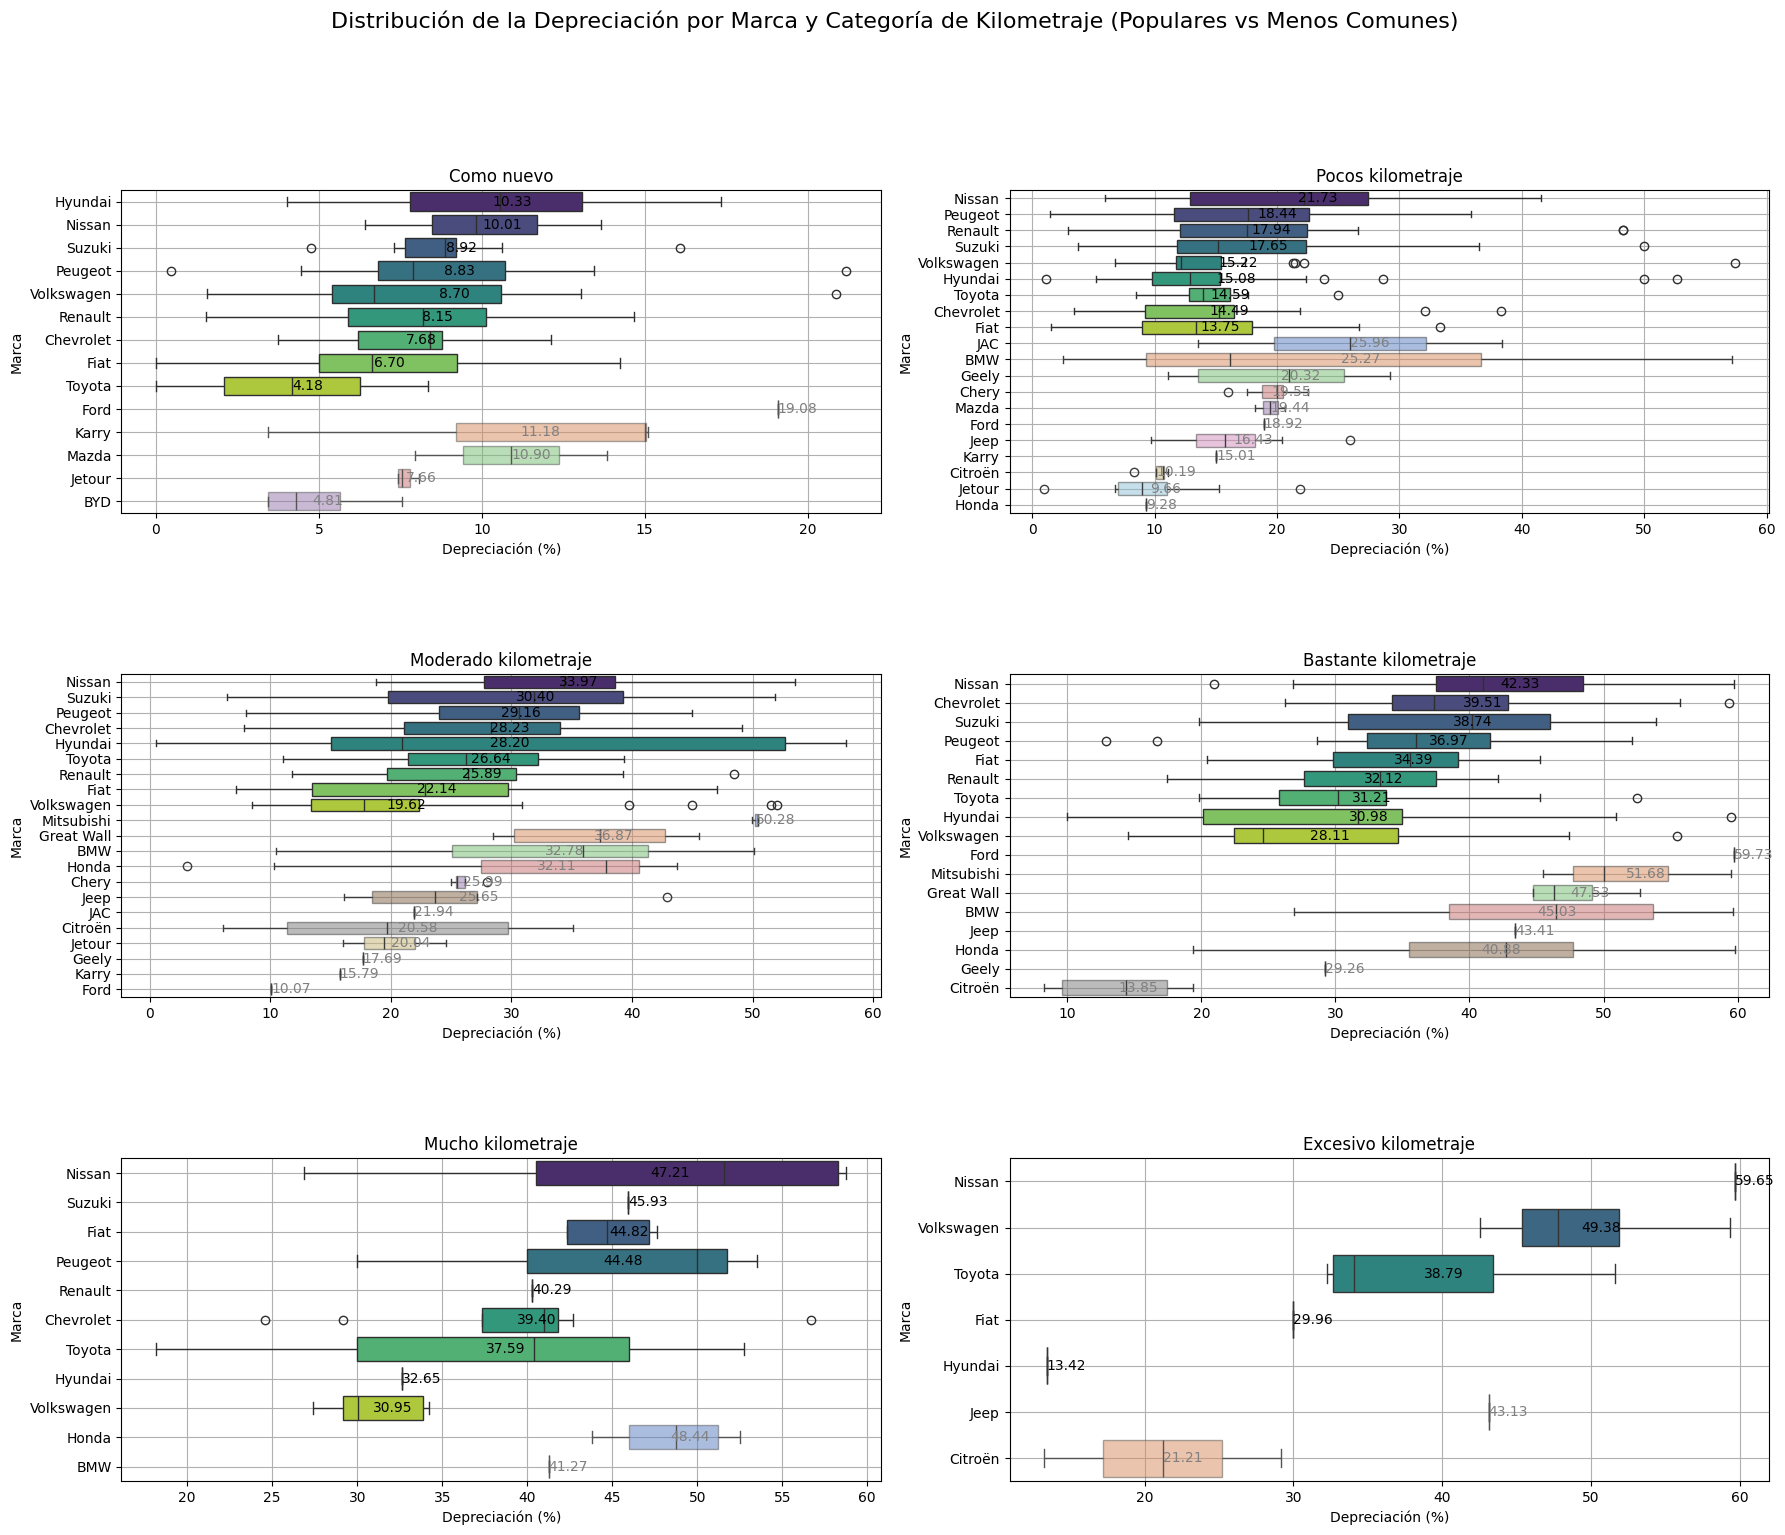

In [272]:

# Asegurar que las categorías de kilometraje están ordenadas
df_filtered['cat_kilometros'] = pd.Categorical(
    df_filtered['cat_kilometros'], 
    categories=[
        'Como nuevo', 'Pocos kilometraje', 'Moderado kilometraje', 
        'Bastante kilometraje', 'Mucho kilometraje', 'Excesivo kilometraje'
    ],
    ordered=True
)

# Separar las marcas populares y menos comunes
marca_counts = df_filtered['marca'].value_counts()
top_marcas = marca_counts[marca_counts > marca_counts.mean()].index
remaining_marcas = marca_counts[marca_counts <= marca_counts.mean()].index

df_top_marcas = df_filtered[df_filtered['marca'].isin(top_marcas)]
df_remaining_marcas = df_filtered[df_filtered['marca'].isin(remaining_marcas)]

# Visualización combinada de marcas populares y menos comunes, separadas por categorías de kilometraje
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for i, cat in enumerate(df_filtered['cat_kilometros'].cat.categories):
    ax = axes[i // 2, i % 2]
    
    # Filtrar el dataframe por la categoría de kilometraje actual
    df_cat_top = df_top_marcas[df_top_marcas['cat_kilometros'] == cat]
    df_cat_remaining = df_remaining_marcas[df_remaining_marcas['cat_kilometros'] == cat]
    
    # Calcular la depreciación promedio por marca dentro de esta categoría
    depreciacion_promedio_top_marca = df_cat_top.groupby('marca')['depreciacion'].mean().sort_values(ascending=False).index
    depreciacion_promedio_remaining_marca = df_cat_remaining.groupby('marca')['depreciacion'].mean().sort_values(ascending=False).index
    
    # Graficar para marcas populares
    sns.boxplot(x='depreciacion', y='marca', data=df_cat_top, order=depreciacion_promedio_top_marca, palette="viridis", ax=ax)
    for j, marca in enumerate(depreciacion_promedio_top_marca):
        media = df_cat_top[df_cat_top['marca'] == marca]['depreciacion'].mean()
        ax.text(media, j, f'{media:.2f}', va='center', ha='left', color='black')
    
    # Graficar para marcas menos comunes en el mismo eje
    sns.boxplot(x='depreciacion', y='marca', data=df_cat_remaining, order=depreciacion_promedio_remaining_marca, palette="muted", ax=ax, boxprops=dict(alpha=.5))
    for j, marca in enumerate(depreciacion_promedio_remaining_marca):
        media = df_cat_remaining[df_cat_remaining['marca'] == marca]['depreciacion'].mean()
        ax.text(media, j + len(depreciacion_promedio_top_marca), f'{media:.2f}', va='center', ha='left', color='grey')

    ax.set_title(f'{cat}')
    ax.set_xlabel('Depreciación (%)')
    ax.set_ylabel('Marca')
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Distribución de la Depreciación por Marca y Categoría de Kilometraje (Populares vs Menos Comunes)', y=1.02, fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

In [273]:
# Calcular el promedio de depreciación para cada marca en todas las categorías de kilometraje
average_depreciation_by_brand = df_filtered.groupby('marca')['depreciacion'].mean().sort_values(ascending=False)

# Mostrar las marcas con mayor depreciación promedio
print(average_depreciation_by_brand)

marca
Mitsubishi    50.978475
Great Wall    41.714348
Honda         36.742775
BMW           35.729545
Nissan        33.062942
Suzuki        29.793917
Toyota        28.240535
Peugeot       27.175686
Chevrolet     25.948586
Ford          25.346716
JAC           23.953344
Renault       23.507598
Jeep          23.082291
Chery         21.888217
Volkswagen    21.441959
Hyundai       21.378850
Geely         20.806823
Fiat          20.046395
Citroën       17.720546
Mazda         15.168220
Karry         12.866789
Jetour        10.763723
BYD            4.812004
Name: depreciacion, dtype: float64


/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/3957550312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cat_kilometros'] = pd.Categorical(
/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/3957550312.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  depreciacion_promedio = df_filtered.groupby(['marca', 'cat_kilometros'])['depreciacion'].mean().reset_index()


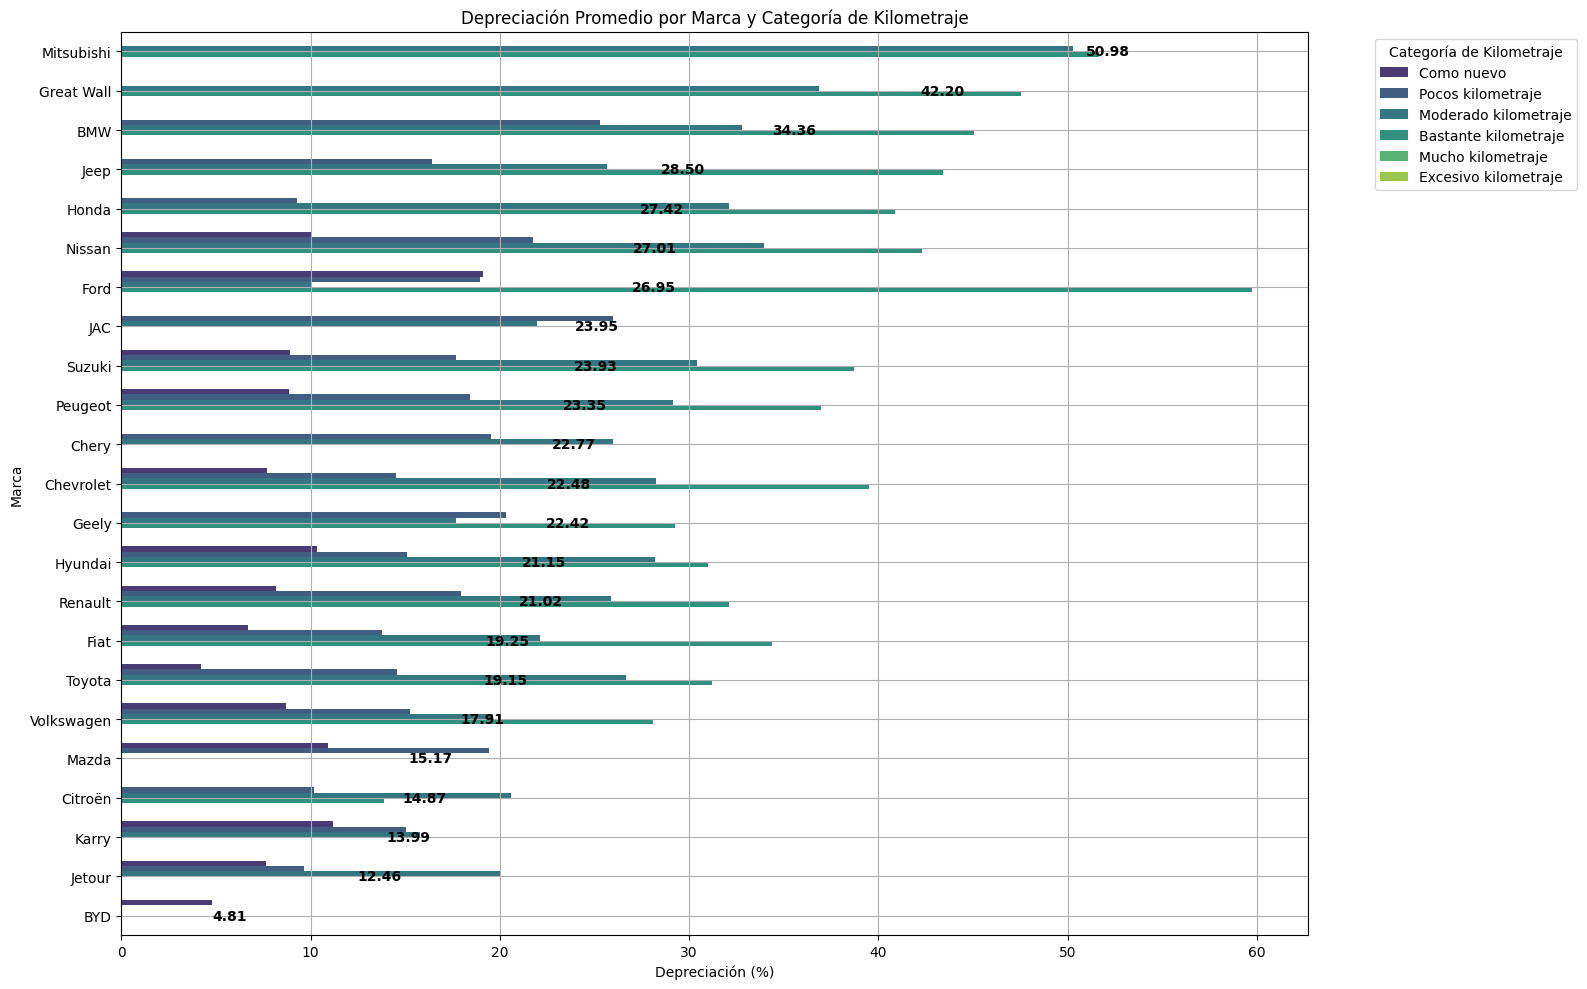

In [274]:
# Asegurar que las categorías de kilometraje están ordenadas
df_filtered['cat_kilometros'] = pd.Categorical(
    df_filtered['cat_kilometros'], 
    categories=[
        'Como nuevo', 'Pocos kilometraje', 'Moderado kilometraje', 
        'Bastante kilometraje', 'Mucho kilometraje', 'Excesivo kilometraje'
    ],
    ordered=True
)

# Filtrar los datos para incluir solo los segmentos de "Como nuevo", "Pocos kilometraje", "Moderado kilometraje" y "Bastante kilometraje"
df_filtered = df_filtered[df_filtered['cat_kilometros'].isin(['Como nuevo', 'Pocos kilometraje', 'Moderado kilometraje', 'Bastante kilometraje'])]

# Calcular el promedio de depreciación por marca para cada segmento de kilometraje
depreciacion_promedio = df_filtered.groupby(['marca', 'cat_kilometros'])['depreciacion'].mean().reset_index()

# Filtrar marcas que están presentes en todos los segmentos requeridos
marcas_completas = depreciacion_promedio['marca'].value_counts()[depreciacion_promedio['marca'].value_counts() == len(df_filtered['cat_kilometros'].cat.categories)].index

# Filtrar el DataFrame para incluir solo esas marcas
depreciacion_promedio_completa = depreciacion_promedio[depreciacion_promedio['marca'].isin(marcas_completas)]

# Calcular el promedio general de depreciación para ordenar las marcas
promedio_global = depreciacion_promedio_completa.groupby('marca')['depreciacion'].mean().sort_values(ascending=False)
depreciacion_promedio_completa['marca'] = pd.Categorical(depreciacion_promedio_completa['marca'], categories=promedio_global.index, ordered=True)

# Crear un gráfico de barras agrupadas para las marcas presentes en todos los segmentos seleccionados
plt.figure(figsize=(16, 10))
sns.barplot(x='depreciacion', y='marca', hue='cat_kilometros', data=depreciacion_promedio_completa, palette="viridis", dodge=True)

# Etiquetas de promedio general para cada marca
for i, marca in enumerate(promedio_global.index):
    media = promedio_global[marca]
    plt.text(media, i, f'{media:.2f}', va='center', ha='left', color='black', fontweight='bold')

plt.title('Depreciación Promedio por Marca y Categoría de Kilometraje')
plt.xlabel('Depreciación (%)')
plt.ylabel('Marca')
plt.legend(title='Categoría de Kilometraje', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## ¿Es más costoso comprar un vehículo de alta gama en términos de depreciación? ¿Qué segmento económico ofrece el mejor valor a largo plazo?

/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/3431013517.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='depreciacion', y='segmento_economico', data=depreciacion_por_segmento, palette="viridis", ax=axes[0])
/var/folders/bb/gj2sfjbd5kz8g_zkvm58s_hm0000gn/T/ipykernel_59438/3431013517.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depreciacion', y='segmento_economico', data=df_filtered, order=depreciacion_por_segmento['segmento_economico'], palette="viridis", ax=axes[1])


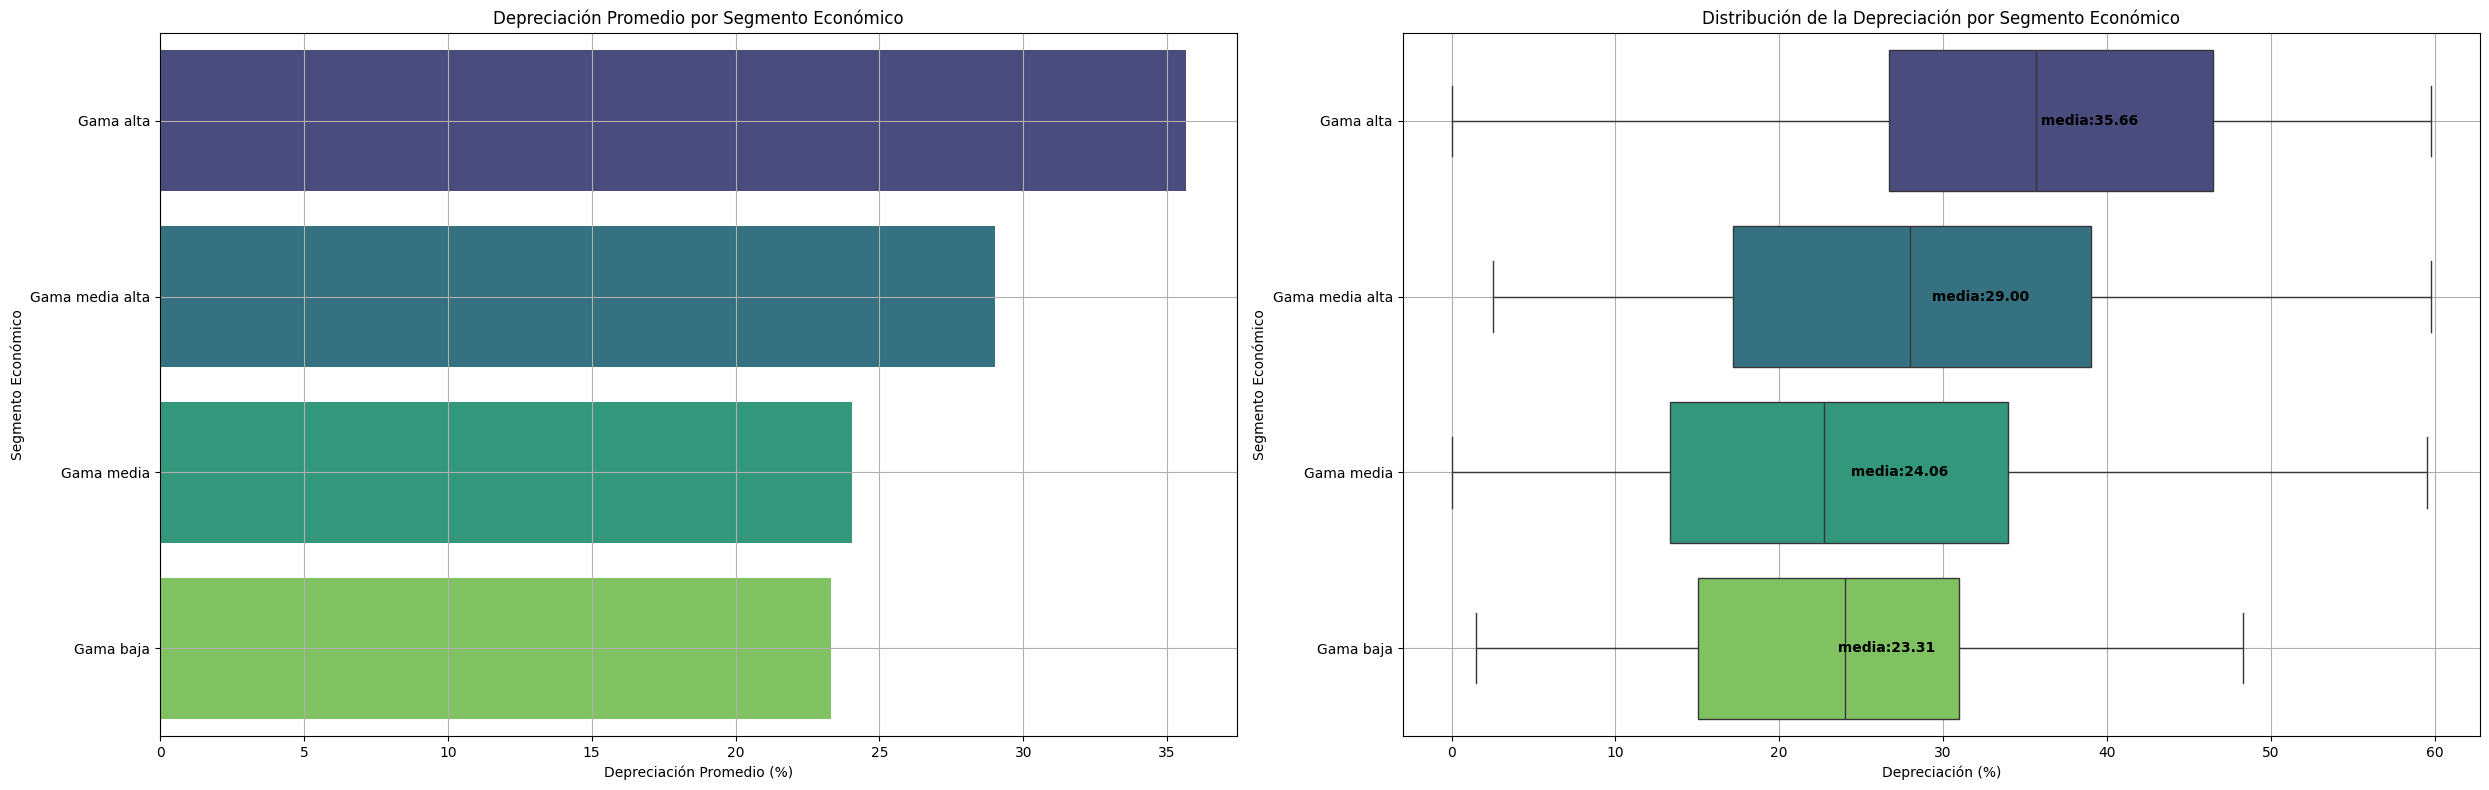

In [275]:
# Calcular la depreciación promedio por segmento económico
depreciacion_por_segmento = df_filtered.groupby('segmento_economico')['depreciacion'].mean().reset_index()
depreciacion_por_segmento = depreciacion_por_segmento.sort_values(by='depreciacion', ascending=False)

# Crear la figura con dos columnas y una fila
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

# Gráfico de barras
sns.barplot(x='depreciacion', y='segmento_economico', data=depreciacion_por_segmento, palette="viridis", ax=axes[0])
axes[0].set_title('Depreciación Promedio por Segmento Económico')
axes[0].set_xlabel('Depreciación Promedio (%)')
axes[0].set_ylabel('Segmento Económico')
axes[0].grid(True)

# Gráfico de caja y bigote
sns.boxplot(x='depreciacion', y='segmento_economico', data=df_filtered, order=depreciacion_por_segmento['segmento_economico'], palette="viridis", ax=axes[1])
axes[1].set_title('Distribución de la Depreciación por Segmento Económico')
axes[1].set_xlabel('Depreciación (%)')
axes[1].set_ylabel('Segmento Económico')
axes[1].grid(True)

for i, segmento in enumerate(depreciacion_por_segmento['segmento_economico']):
    media = depreciacion_por_segmento[depreciacion_por_segmento['segmento_economico'] == segmento]['depreciacion'].values[0]
    axes[1].text(media, i, f' media:{media:.2f}', va='center', ha='left', color='black', fontweight='bold')


# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

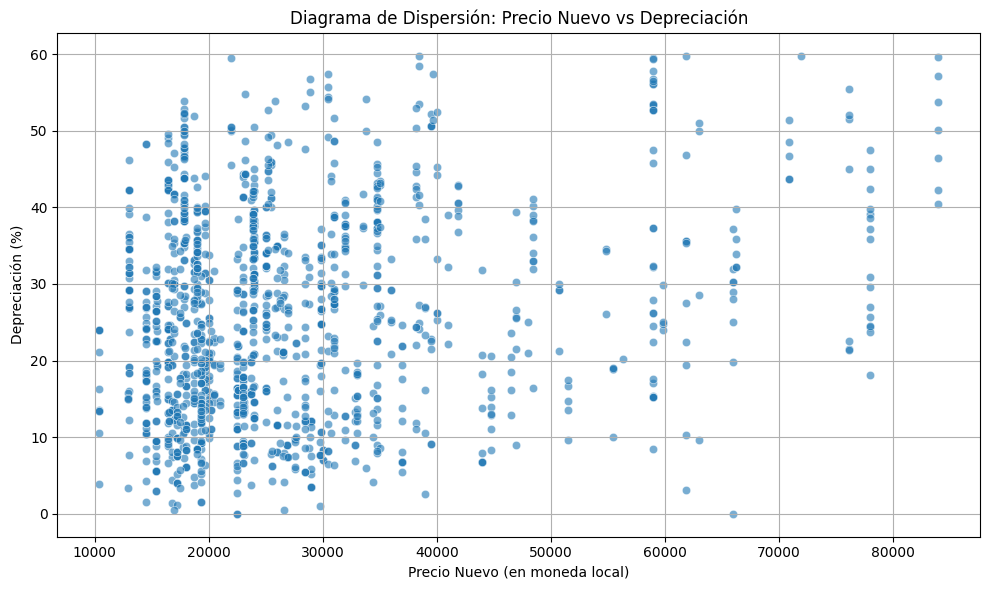

p-value: 1.653894490032352e-17, R-squared: 0.04943157869224058


In [276]:
# Crear un diagrama de dispersión entre precio_nuevo y depreciación
plt.figure(figsize=(10, 6))
sns.scatterplot(x='precio_nuevo', y='depreciacion', data=df_filtered, alpha=0.6)
plt.title('Diagrama de Dispersión: Precio Nuevo vs Depreciación')
plt.xlabel('Precio Nuevo (en moneda local)')
plt.ylabel('Depreciación (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis estadístico: cálculo del p-valor para la relación entre precio_nuevo y depreciación
slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered['precio_nuevo'], df_filtered['depreciacion'])

# Mostrar los resultados del análisis
print(f"p-value: {p_value}, R-squared: {r_value ** 2}")